In [2]:
import pandas as pd
import os
import glob

def filter_demographic_files():
    """Filter demographic files to include only approved HN Numbers and combine by year"""
    
    # File paths
    input_folder = "./Sepsis_plt/demographic/"
    hn_list_file = "./Sepsis_plt/Sepsis plt/plt_ASEhn_ALL.txt"
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/"
    
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)
    
    # Check if HN list file exists
    if not os.path.exists(hn_list_file):
        print(f"Error: HN list file not found at {hn_list_file}")
        return
    
    # Check if input folder exists
    if not os.path.exists(input_folder):
        print(f"Error: Demographic folder not found at {input_folder}")
        return
    
    print("Reading approved HN list...")
    
    # Read the HN list file
    try:
        with open(hn_list_file, 'r', encoding='utf-8') as f:
            hn_lines = f.readlines()
        
        # Extract HN Numbers from the text file (format: {text},{HN Number})
        approved_hn_numbers = set()
        for line in hn_lines:
            line = line.strip()
            if line and ',' in line:
                # Get the part after the last comma (HN Number)
                hn_number = line.split(',')[-1].strip()
                if hn_number:
                    approved_hn_numbers.add(hn_number)
        
        print(f"✓ Approved HN list read: {len(approved_hn_numbers):,} unique HN numbers")
        
    except Exception as e:
        print(f"✗ Error reading HN list file: {e}")
        return
    
    # Find all demographic files
    pattern = os.path.join(input_folder, "*_presumedInfection_Demographic_*.csv")
    demographic_files = glob.glob(pattern)
    
    if not demographic_files:
        print(f"No demographic files found in {input_folder}")
        print(f"Pattern used: {pattern}")
        return
    
    print(f"Found {len(demographic_files)} demographic files")
    
    # Group files by year
    files_by_year = {}
    
    for file_path in demographic_files:
        try:
            filename = os.path.basename(file_path)
            # Extract year from filename: {numbers}_presumedInfection_Demographic_{year}_P{part}.csv
            parts = filename.split('_')
            year_part = None
            for i, part in enumerate(parts):
                if part == "Demographic":
                    if i + 1 < len(parts):
                        year_part = parts[i + 1]
                        break
            
            if year_part and year_part.isdigit():
                year = int(year_part)
                if year not in files_by_year:
                    files_by_year[year] = []
                files_by_year[year].append(file_path)
            else:
                print(f"  Could not extract year from: {filename}")
                
        except Exception as e:
            print(f"  Error processing filename {file_path}: {e}")
            continue
    
    print(f"\nFiles grouped by year:")
    for year in sorted(files_by_year.keys()):
        print(f"  {year}: {len(files_by_year[year])} files")
    
    # Process each year
    all_filtered_data = []
    yearly_summary = []
    
    for year in sorted(files_by_year.keys()):
        print(f"\nProcessing year {year}...")
        
        year_files = files_by_year[year]
        all_parts_data = []
        
        for file_path in year_files:
            try:
                filename = os.path.basename(file_path)
                df = pd.read_csv(file_path)
                all_parts_data.append(df)
                print(f"  ✓ Read {filename}: {len(df)} rows")
                
            except Exception as e:
                print(f"  ✗ Error reading {file_path}: {e}")
                continue
        
        if all_parts_data:
            # Combine all parts for this year
            combined_df = pd.concat(all_parts_data, ignore_index=True)
            original_rows = len(combined_df)
            
            # Filter to only include approved HN numbers
            if 'HN Number' in combined_df.columns:
                # Convert HN Number to string for comparison
                combined_df['HN Number'] = combined_df['HN Number'].astype(str)
                filtered_df = combined_df[combined_df['HN Number'].isin(approved_hn_numbers)]
                
                # Add year column if not present
                if 'Year' not in filtered_df.columns:
                    filtered_df['Year'] = year
                
                # Save individual year file
                output_file = os.path.join(output_folder, f"demographic_{year}_filtered.csv")
                filtered_df.to_csv(output_file, index=False)
                
                filtered_rows = len(filtered_df)
                all_filtered_data.append(filtered_df)
                
                yearly_summary.append({
                    'Year': year,
                    'Original_Rows': original_rows,
                    'Filtered_Rows': filtered_rows,
                    'Removed_Rows': original_rows - filtered_rows,
                    'Percentage_Kept': (filtered_rows / original_rows * 100) if original_rows > 0 else 0
                })
                
                print(f"  ✓ Saved demographic_{year}_filtered.csv")
                print(f"    Original: {original_rows:,} rows")
                print(f"    Filtered: {filtered_rows:,} rows")
                print(f"    Removed: {original_rows - filtered_rows:,} rows")
                print(f"    Kept: {filtered_rows/original_rows*100:.1f}%")
                
            else:
                print(f"  ✗ 'HN Number' column not found in year {year} data")
        else:
            print(f"  ✗ No data could be read for year {year}")
    
    # Create master combined file
    if all_filtered_data:
        print(f"\nCreating master combined file...")
        master_df = pd.concat(all_filtered_data, ignore_index=True)
        
        # Save master file
        master_file = os.path.join(output_folder, "demographic_ALL_YEARS_filtered.csv")
        master_df.to_csv(master_file, index=False)
        
        print(f"✓ Master file saved: demographic_ALL_YEARS_filtered.csv")
        print(f"  Total rows in master: {len(master_df):,}")
        print(f"  Years included: {len(yearly_summary)}")
    
    # Save summary statistics
    if yearly_summary:
        summary_df = pd.DataFrame(yearly_summary)
        summary_file = os.path.join(output_folder, "demographic_filtering_summary.csv")
        summary_df.to_csv(summary_file, index=False)
        
        print(f"\n✓ Summary saved: demographic_filtering_summary.csv")
        
        # Print overall summary
        total_original = sum(item['Original_Rows'] for item in yearly_summary)
        total_filtered = sum(item['Filtered_Rows'] for item in yearly_summary)
        
        print("\n" + "="*60)
        print("OVERALL FILTERING SUMMARY")
        print("="*60)
        print(f"Total original rows: {total_original:,}")
        print(f"Total filtered rows: {total_filtered:,}")
        print(f"Total removed rows: {total_original - total_filtered:,}")
        print(f"Overall percentage kept: {total_filtered/total_original*100:.1f}%")
        
        # Show years with most data loss
        if len(yearly_summary) > 1:
            print(f"\nYears with highest data removal:")
            sorted_by_removal = sorted(yearly_summary, key=lambda x: x['Removed_Rows'], reverse=True)
            for i, year_data in enumerate(sorted_by_removal[:3]):
                print(f"  {year_data['Year']}: {year_data['Removed_Rows']:,} rows removed ({year_data['Percentage_Kept']:.1f}% kept)")
    
    # List all created files
    print(f"\n✓ Created files in {output_folder}:")
    for file in os.listdir(output_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(output_folder, file)
            file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
            print(f"  - {file} ({file_size:.1f} MB)")

def main():
    """Main function to filter demographic files"""
    print("Filtering demographic files to include only approved HN numbers...")
    filter_demographic_files()
    print(f"\n✅ Filtering complete! All filtered files saved to: ./demographic/filtered_approved_hn/")

if __name__ == "__main__":
    main()

Filtering demographic files to include only approved HN numbers...
Reading approved HN list...
✓ Approved HN list read: 68,722 unique HN numbers
Found 507 demographic files
  Could not extract year from: 8120050_presumedInfection_Demographic_20250526.csv

Files grouped by year:
  2001: 4 files
  2002: 9 files
  2003: 12 files
  2004: 14 files
  2005: 15 files
  2006: 14 files
  2007: 14 files
  2008: 16 files
  2009: 17 files
  2010: 18 files
  2011: 18 files
  2012: 19 files
  2013: 19 files
  2014: 23 files
  2015: 24 files
  2016: 25 files
  2017: 27 files
  2018: 28 files
  2019: 34 files
  2020: 29 files
  2021: 31 files
  2022: 30 files
  2023: 31 files
  2024: 35 files

Processing year 2001...
  ✓ Read 8064239_presumedInfection_Demographic_2001_P1.csv: 16491 rows
  ✓ Read 8064241_presumedInfection_Demographic_2001_P2.csv: 15884 rows
  ✓ Read 8064243_presumedInfection_Demographic_2001_P3.csv: 16602 rows
  ✓ Read 8064244_presumedInfection_Demographic_2001_P4.csv: 13849 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2001_filtered.csv
    Original: 62,826 rows
    Filtered: 4,218 rows
    Removed: 58,608 rows
    Kept: 6.7%

Processing year 2002...
  ✓ Read 8064246_presumedInfection_Demographic_2002_P1.csv: 15622 rows
  ✓ Read 8064248_presumedInfection_Demographic_2002_P2.csv: 15920 rows
  ✓ Read 8064250_presumedInfection_Demographic_2002_P3.csv: 15339 rows
  ✓ Read 8064252_presumedInfection_Demographic_2002_P4.csv: 15539 rows
  ✓ Read 8064254_presumedInfection_Demographic_2002_P5.csv: 16261 rows
  ✓ Read 8064257_presumedInfection_Demographic_2002_P6.csv: 4260 rows
  ✓ Read 8066766_presumedInfection_Demographic_2002_V25_P1.csv: 26419 rows
  ✓ Read 8066769_presumedInfection_Demographic_2002_V25_P2.csv: 26225 rows
  ✓ Read 8066771_presumedInfection_Demographic_2002_V25_P3.csv: 17657 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2002_filtered.csv
    Original: 153,242 rows
    Filtered: 4,500 rows
    Removed: 148,742 rows
    Kept: 2.9%

Processing year 2003...
  ✓ Read 8064262_presumedInfection_Demographic_2003_P1.csv: 16054 rows
  ✓ Read 8064272_presumedInfection_Demographic_2003_P2.csv: 15691 rows
  ✓ Read 8064278_presumedInfection_Demographic_2003_P3.csv: 13604 rows
  ✓ Read 8064293_presumedInfection_Demographic_2003_P4.csv: 13699 rows
  ✓ Read 8064294_presumedInfection_Demographic_2003_P5.csv: 14800 rows
  ✓ Read 8064295_presumedInfection_Demographic_2003_P6.csv: 15402 rows
  ✓ Read 8064296_presumedInfection_Demographic_2003_P7.csv: 15943 rows
  ✓ Read 8064298_presumedInfection_Demographic_2003_P8.csv: 15648 rows
  ✓ Read 8064300_presumedInfection_Demographic_2003_P9.csv: 15541 rows
  ✓ Read 8064303_presumedInfection_Demographic_2003_P10.csv: 16299 rows
  ✓ Read 8064304_presumedInfection_Demographic_2003_P11.csv: 16263 rows
  ✓ Read 8064306_presumedInfection_Demographic_2003_P12.csv

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8064318_presumedInfection_Demographic_2004_P4.csv: 15215 rows
  ✓ Read 8064319_presumedInfection_Demographic_2004_P5.csv: 14870 rows
  ✓ Read 8064321_presumedInfection_Demographic_2004_P6.csv: 14525 rows
  ✓ Read 8064322_presumedInfection_Demographic_2004_P7.csv: 14121 rows
  ✓ Read 8064323_presumedInfection_Demographic_2004_P8.csv: 13880 rows
  ✓ Read 8064324_presumedInfection_Demographic_2004_P9.csv: 14602 rows
  ✓ Read 8064327_presumedInfection_Demographic_2004_P10.csv: 14415 rows
  ✓ Read 8064328_presumedInfection_Demographic_2004_P11.csv: 14702 rows
  ✓ Read 8064329_presumedInfection_Demographic_2004_P12.csv: 15609 rows
  ✓ Read 8064330_presumedInfection_Demographic_2004_P13.csv: 15397 rows
  ✓ Read 8064332_presumedInfection_Demographic_2004_P14.csv: 6905 rows
  ✓ Saved demographic_2004_filtered.csv
    Original: 199,944 rows
    Filtered: 15,822 rows
    Removed: 184,122 rows
    Kept: 7.9%

Processing year 2005...


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8064336_presumedInfection_Demographic_2005_P1.csv: 15283 rows
  ✓ Read 8064337_presumedInfection_Demographic_2005_P2.csv: 15677 rows
  ✓ Read 8064360_presumedInfection_Demographic_2005_P3.csv: 14643 rows
  ✓ Read 8064369_presumedInfection_Demographic_2005_P4.csv: 13895 rows
  ✓ Read 8064374_presumedInfection_Demographic_2005_P5.csv: 14332 rows
  ✓ Read 8064379_presumedInfection_Demographic_2005_P6.csv: 13666 rows
  ✓ Read 8064386_presumedInfection_Demographic_2005_P7.csv: 14024 rows
  ✓ Read 8064399_presumedInfection_Demographic_2005_P8.csv: 14488 rows
  ✓ Read 8064406_presumedInfection_Demographic_2005_P9.csv: 15500 rows
  ✓ Read 8064412_presumedInfection_Demographic_2005_P10.csv: 15685 rows
  ✓ Read 8064416_presumedInfection_Demographic_2005_P11.csv: 15309 rows
  ✓ Read 8064420_presumedInfection_Demographic_2005_P12.csv: 15775 rows
  ✓ Read 8064423_presumedInfection_Demographic_2005_P13.csv: 16183 rows
  ✓ Read 8064427_presumedInfection_Demographic_2005_P14.csv: 15473 rows
 

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8064444_presumedInfection_Demographic_2006_P2.csv: 16476 rows
  ✓ Read 8064445_presumedInfection_Demographic_2006_P3.csv: 15996 rows
  ✓ Read 8064447_presumedInfection_Demographic_2006_P4.csv: 16353 rows
  ✓ Read 8064450_presumedInfection_Demographic_2006_P5.csv: 15259 rows
  ✓ Read 8064454_presumedInfection_Demographic_2006_P6.csv: 15756 rows
  ✓ Read 8064455_presumedInfection_Demographic_2006_P7.csv: 15219 rows
  ✓ Read 8064457_presumedInfection_Demographic_2006_P8.csv: 15821 rows
  ✓ Read 8064459_presumedInfection_Demographic_2006_P9.csv: 16042 rows
  ✓ Read 8064460_presumedInfection_Demographic_2006_P10.csv: 16109 rows
  ✓ Read 8064461_presumedInfection_Demographic_2006_P11.csv: 15830 rows
  ✓ Read 8064463_presumedInfection_Demographic_2006_P12.csv: 16278 rows
  ✓ Read 8064465_presumedInfection_Demographic_2006_P13.csv: 16143 rows
  ✓ Read 8064466_presumedInfection_Demographic_2006_P14.csv: 5444 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2006_filtered.csv
    Original: 211,911 rows
    Filtered: 19,143 rows
    Removed: 192,768 rows
    Kept: 9.0%

Processing year 2007...
  ✓ Read 8064705_presumedInfection_Demographic_2007_P1.csv: 15798 rows
  ✓ Read 8064715_presumedInfection_Demographic_2007_P2.csv: 15750 rows
  ✓ Read 8064726_presumedInfection_Demographic_2007_P3.csv: 16315 rows
  ✓ Read 8064730_presumedInfection_Demographic_2007_P4.csv: 15910 rows
  ✓ Read 8064733_presumedInfection_Demographic_2007_P5.csv: 16279 rows
  ✓ Read 8064738_presumedInfection_Demographic_2007_P6.csv: 16068 rows
  ✓ Read 8064742_presumedInfection_Demographic_2007_P7.csv: 14860 rows
  ✓ Read 8064746_presumedInfection_Demographic_2007_P8.csv: 15881 rows
  ✓ Read 8064748_presumedInfection_Demographic_2007_P9.csv: 16692 rows
  ✓ Read 8064750_presumedInfection_Demographic_2007_P10.csv: 16885 rows
  ✓ Read 8064753_presumedInfection_Demographic_2007_P11.csv: 16998 rows
  ✓ Read 8064755_presumedInfection_Demographic_2007_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8064784_presumedInfection_Demographic_2008_P1.csv: 17041 rows
  ✓ Read 8064788_presumedInfection_Demographic_2008_P2.csv: 17824 rows
  ✓ Read 8064790_presumedInfection_Demographic_2008_P3.csv: 17879 rows
  ✓ Read 8064794_presumedInfection_Demographic_2008_P4.csv: 18485 rows
  ✓ Read 8064798_presumedInfection_Demographic_2008_P5.csv: 19207 rows
  ✓ Read 8064801_presumedInfection_Demographic_2008_P6.csv: 18968 rows
  ✓ Read 8064804_presumedInfection_Demographic_2008_P7.csv: 19606 rows
  ✓ Read 8064807_presumedInfection_Demographic_2008_P8.csv: 19934 rows
  ✓ Read 8064811_presumedInfection_Demographic_2008_P9.csv: 19247 rows
  ✓ Read 8064814_presumedInfection_Demographic_2008_P10.csv: 19474 rows
  ✓ Read 8064815_presumedInfection_Demographic_2008_P11.csv: 20024 rows
  ✓ Read 8064817_presumedInfection_Demographic_2008_P12.csv: 20972 rows
  ✓ Read 8064820_presumedInfection_Demographic_2008_P13.csv: 22049 rows
  ✓ Read 8064822_presumedInfection_Demographic_2008_P14.csv: 23785 rows
 

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8064833_presumedInfection_Demographic_2009_P2.csv: 25603 rows
  ✓ Read 8064838_presumedInfection_Demographic_2009_P3.csv: 26732 rows
  ✓ Read 8064841_presumedInfection_Demographic_2009_P4.csv: 27010 rows
  ✓ Read 8064846_presumedInfection_Demographic_2009_P5.csv: 26336 rows
  ✓ Read 8064851_presumedInfection_Demographic_2009_P6.csv: 26760 rows
  ✓ Read 8064855_presumedInfection_Demographic_2009_P7.csv: 26754 rows
  ✓ Read 8064858_presumedInfection_Demographic_2009_P8.csv: 27816 rows
  ✓ Read 8064860_presumedInfection_Demographic_2009_P9.csv: 28231 rows
  ✓ Read 8064864_presumedInfection_Demographic_2009_P10.csv: 29564 rows
  ✓ Read 8064866_presumedInfection_Demographic_2009_P11.csv: 28143 rows
  ✓ Read 8064869_presumedInfection_Demographic_2009_P12.csv: 29662 rows
  ✓ Read 8064875_presumedInfection_Demographic_2009_P13.csv: 30749 rows
  ✓ Read 8064877_presumedInfection_Demographic_2009_P14.csv: 31183 rows
  ✓ Read 8064878_presumedInfection_Demographic_2009_P15.csv: 19596 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8064881_presumedInfection_Demographic_2010_P1.csv: 31903 rows
  ✓ Read 8064884_presumedInfection_Demographic_2010_P2.csv: 31736 rows
  ✓ Read 8064886_presumedInfection_Demographic_2010_P3.csv: 30948 rows
  ✓ Read 8064888_presumedInfection_Demographic_2010_P4.csv: 32347 rows
  ✓ Read 8064890_presumedInfection_Demographic_2010_P5.csv: 31667 rows
  ✓ Read 8064895_presumedInfection_Demographic_2010_P6.csv: 31965 rows
  ✓ Read 8064898_presumedInfection_Demographic_2010_P7.csv: 32418 rows
  ✓ Read 8064904_presumedInfection_Demographic_2010_P8.csv: 32238 rows
  ✓ Read 8064908_presumedInfection_Demographic_2010_P9.csv: 30834 rows
  ✓ Read 8064913_presumedInfection_Demographic_2010_P10.csv: 33596 rows
  ✓ Read 8064920_presumedInfection_Demographic_2010_P11.csv: 32374 rows
  ✓ Read 8064922_presumedInfection_Demographic_2010_P12.csv: 10458 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  ✓ Read 8066778_presumedInfection_Demographic_2010_V25_P1.csv: 55997 rows
  ✓ Read 8066779_presumedInfection_Demographic_2010_V25_P2.csv: 56987 rows
  ✓ Read 8066780_presumedInfection_Demographic_2010_V25_P3.csv: 56857 rows
  ✓ Read 8066783_presumedInfection_Demographic_2010_V25_P4.csv: 56210 rows
  ✓ Read 8066785_presumedInfection_Demographic_2010_V25_P5.csv: 56004 rows
  ✓ Read 8066786_presumedInfection_Demographic_2010_V25_P6.csv: 29057 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2010_filtered.csv
    Original: 673,596 rows
    Filtered: 22,868 rows
    Removed: 650,728 rows
    Kept: 3.4%

Processing year 2011...
  ✓ Read 8064925_presumedInfection_Demographic_2011_P1.csv: 32110 rows
  ✓ Read 8064928_presumedInfection_Demographic_2011_P2.csv: 32013 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  ✓ Read 8064932_presumedInfection_Demographic_2011_P3.csv: 33101 rows
  ✓ Read 8064933_presumedInfection_Demographic_2011_P4.csv: 30674 rows
  ✓ Read 8064936_presumedInfection_Demographic_2011_P5.csv: 30817 rows
  ✓ Read 8064938_presumedInfection_Demographic_2011_P6.csv: 30059 rows
  ✓ Read 8064940_presumedInfection_Demographic_2011_P7.csv: 30815 rows
  ✓ Read 8064942_presumedInfection_Demographic_2011_P8.csv: 31391 rows
  ✓ Read 8064945_presumedInfection_Demographic_2011_P9.csv: 30120 rows
  ✓ Read 8064947_presumedInfection_Demographic_2011_P10.csv: 32451 rows
  ✓ Read 8064949_presumedInfection_Demographic_2011_P11.csv: 31769 rows
  ✓ Read 8064950_presumedInfection_Demographic_2011_P12.csv: 31362 rows
  ✓ Read 8064951_presumedInfection_Demographic_2011_P13.csv: 7171 rows
  ✓ Read 8066787_presumedInfection_Demographic_2011_V25_P1.csv: 49129 rows
  ✓ Read 8066788_presumedInfection_Demographic_2011_V25_P2.csv: 50264 rows
  ✓ Read 8066790_presumedInfection_Demographic_2011_V25_P3.csv: 49

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2011_filtered.csv
    Original: 581,678 rows
    Filtered: 27,352 rows
    Removed: 554,326 rows
    Kept: 4.7%

Processing year 2012...
  ✓ Read 8064953_presumedInfection_Demographic_2012_P1.csv: 29207 rows
  ✓ Read 8064956_presumedInfection_Demographic_2012_P2.csv: 28908 rows
  ✓ Read 8064957_presumedInfection_Demographic_2012_P3.csv: 29226 rows
  ✓ Read 8064959_presumedInfection_Demographic_2012_P4.csv: 28611 rows
  ✓ Read 8064961_presumedInfection_Demographic_2012_P5.csv: 28896 rows
  ✓ Read 8064963_presumedInfection_Demographic_2012_P6.csv: 28216 rows
  ✓ Read 8064965_presumedInfection_Demographic_2012_P7.csv: 28211 rows
  ✓ Read 8064968_presumedInfection_Demographic_2012_P8.csv: 28790 rows
  ✓ Read 8064975_presumedInfection_Demographic_2012_P9.csv: 28676 rows
  ✓ Read 8064976_presumedInfection_Demographic_2012_P10.csv: 29197 rows
  ✓ Read 8064978_presumedInfection_Demographic_2012_P11.csv: 28844 rows
  ✓ Read 8064981_presumedInfection_Demographic_2012_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8064991_presumedInfection_Demographic_2013_P1.csv: 27596 rows
  ✓ Read 8064992_presumedInfection_Demographic_2013_P2.csv: 27194 rows
  ✓ Read 8064993_presumedInfection_Demographic_2013_P3.csv: 26083 rows
  ✓ Read 8064994_presumedInfection_Demographic_2013_P4.csv: 26181 rows
  ✓ Read 8064995_presumedInfection_Demographic_2013_P5.csv: 25677 rows
  ✓ Read 8064996_presumedInfection_Demographic_2013_P6.csv: 26902 rows
  ✓ Read 8064998_presumedInfection_Demographic_2013_P7.csv: 26046 rows
  ✓ Read 8065000_presumedInfection_Demographic_2013_P8.csv: 26033 rows
  ✓ Read 8065004_presumedInfection_Demographic_2013_P9.csv: 26205 rows
  ✓ Read 8065007_presumedInfection_Demographic_2013_P10.csv: 26173 rows
  ✓ Read 8065011_presumedInfection_Demographic_2013_P11.csv: 25465 rows
  ✓ Read 8065016_presumedInfection_Demographic_2013_P12.csv: 25152 rows
  ✓ Read 8065022_presumedInfection_Demographic_2013_P13.csv: 25973 rows
  ✓ Read 8065043_presumedInfection_Demographic_2013_P14.csv: 25680 rows
 

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Read 8065080_presumedInfection_Demographic_2014_P1.csv: 24701 rows
  ✓ Read 8065081_presumedInfection_Demographic_2014_P2.csv: 24655 rows
  ✓ Read 8065083_presumedInfection_Demographic_2014_P3.csv: 25621 rows
  ✓ Read 8065084_presumedInfection_Demographic_2014_P4.csv: 26173 rows
  ✓ Read 8065087_presumedInfection_Demographic_2014_P5.csv: 25776 rows
  ✓ Read 8065088_presumedInfection_Demographic_2014_P6.csv: 25168 rows
  ✓ Read 8065089_presumedInfection_Demographic_2014_P7.csv: 24938 rows
  ✓ Read 8065090_presumedInfection_Demographic_2014_P8.csv: 24297 rows
  ✓ Read 8065092_presumedInfection_Demographic_2014_P9.csv: 24769 rows
  ✓ Read 8065093_presumedInfection_Demographic_2014_P10.csv: 25189 rows
  ✓ Read 8065094_presumedInfection_Demographic_2014_P11.csv: 24335 rows
  ✓ Read 8065097_presumedInfection_Demographic_2014_P12.csv: 24176 rows
  ✓ Read 8065099_presumedInfection_Demographic_2014_P13.csv: 24635 rows
  ✓ Read 8065100_presumedInfection_Demographic_2014_P14.csv: 25068 rows
 

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2014_filtered.csv
    Original: 572,146 rows
    Filtered: 42,217 rows
    Removed: 529,929 rows
    Kept: 7.4%

Processing year 2015...
  ✓ Read 8065112_presumedInfection_Demographic_2015_P1.csv: 23375 rows
  ✓ Read 8065114_presumedInfection_Demographic_2015_P2.csv: 22839 rows
  ✓ Read 8065116_presumedInfection_Demographic_2015_P3.csv: 23769 rows
  ✓ Read 8065118_presumedInfection_Demographic_2015_P4.csv: 23384 rows
  ✓ Read 8065120_presumedInfection_Demographic_2015_P5.csv: 23833 rows
  ✓ Read 8065122_presumedInfection_Demographic_2015_P6.csv: 24102 rows
  ✓ Read 8065124_presumedInfection_Demographic_2015_P7.csv: 23907 rows
  ✓ Read 8065127_presumedInfection_Demographic_2015_P8.csv: 24964 rows
  ✓ Read 8065128_presumedInfection_Demographic_2015_P9.csv: 24839 rows
  ✓ Read 8065131_presumedInfection_Demographic_2015_P10.csv: 25471 rows
  ✓ Read 8065132_presumedInfection_Demographic_2015_P11.csv: 24023 rows
  ✓ Read 8065134_presumedInfection_Demographic_2015_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2015_filtered.csv
    Original: 575,807 rows
    Filtered: 43,513 rows
    Removed: 532,294 rows
    Kept: 7.6%

Processing year 2016...
  ✓ Read 8065160_presumedInfection_Demographic_2016_P1.csv: 25312 rows
  ✓ Read 8065165_presumedInfection_Demographic_2016_P2.csv: 25405 rows
  ✓ Read 8065167_presumedInfection_Demographic_2016_P3.csv: 24835 rows
  ✓ Read 8065169_presumedInfection_Demographic_2016_P4.csv: 25154 rows
  ✓ Read 8065170_presumedInfection_Demographic_2016_P5.csv: 25215 rows
  ✓ Read 8065171_presumedInfection_Demographic_2016_P6.csv: 25269 rows
  ✓ Read 8065172_presumedInfection_Demographic_2016_P7.csv: 24710 rows
  ✓ Read 8065174_presumedInfection_Demographic_2016_P8.csv: 25333 rows
  ✓ Read 8065175_presumedInfection_Demographic_2016_P9.csv: 24264 rows
  ✓ Read 8065176_presumedInfection_Demographic_2016_P10.csv: 25258 rows
  ✓ Read 8065178_presumedInfection_Demographic_2016_P11.csv: 24698 rows
  ✓ Read 8065180_presumedInfection_Demographic_2016_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  ✓ Read 8066803_presumedInfection_Demographic_2016_V25_P1.csv: 33811 rows
  ✓ Read 8066805_presumedInfection_Demographic_2016_V25_P2.csv: 33969 rows
  ✓ Read 8066806_presumedInfection_Demographic_2016_V25_P3.csv: 34161 rows
  ✓ Read 8066808_presumedInfection_Demographic_2016_V25_P4.csv: 16760 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2016_filtered.csv
    Original: 627,617 rows
    Filtered: 38,811 rows
    Removed: 588,806 rows
    Kept: 6.2%

Processing year 2017...
  ✓ Read 8066325_presumedInfection_Demographic_2017_P1.csv: 24603 rows
  ✓ Read 8066326_presumedInfection_Demographic_2017_P2.csv: 24811 rows
  ✓ Read 8066327_presumedInfection_Demographic_2017_P3.csv: 25058 rows
  ✓ Read 8066328_presumedInfection_Demographic_2017_P4.csv: 24312 rows
  ✓ Read 8066330_presumedInfection_Demographic_2017_P5.csv: 23704 rows
  ✓ Read 8066331_presumedInfection_Demographic_2017_P6.csv: 23894 rows
  ✓ Read 8066332_presumedInfection_Demographic_2017_P7.csv: 23460 rows
  ✓ Read 8066333_presumedInfection_Demographic_2017_P8.csv: 23027 rows
  ✓ Read 8066334_presumedInfection_Demographic_2017_P9.csv: 23172 rows
  ✓ Read 8066335_presumedInfection_Demographic_2017_P10.csv: 23940 rows
  ✓ Read 8066345_presumedInfection_Demographic_2017_P11.csv: 25380 rows
  ✓ Read 8066347_presumedInfection_Demographic_2017_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  ✓ Read 8066825_presumedInfection_Demographic_2017_V25_P5.csv: 37199 rows
  ✓ Read 8066827_presumedInfection_Demographic_2017_V25_P6.csv: 36698 rows
  ✓ Read 8066829_presumedInfection_Demographic_2017_V25_P7.csv: 36925 rows
  ✓ Read 8066830_presumedInfection_Demographic_2017_V25_P8.csv: 36601 rows
  ✓ Read 8066833_presumedInfection_Demographic_2017_V25_P9.csv: 37558 rows
  ✓ Read 8066835_presumedInfection_Demographic_2017_V25_P10.csv: 14423 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2017_filtered.csv
    Original: 748,066 rows
    Filtered: 32,445 rows
    Removed: 715,621 rows
    Kept: 4.3%

Processing year 2018...
  ✓ Read 8066368_presumedInfection_Demographic_2018_P1.csv: 23279 rows
  ✓ Read 8066371_presumedInfection_Demographic_2018_P2.csv: 23061 rows
  ✓ Read 8066375_presumedInfection_Demographic_2018_P3.csv: 23800 rows
  ✓ Read 8066380_presumedInfection_Demographic_2018_P4.csv: 22681 rows
  ✓ Read 8066384_presumedInfection_Demographic_2018_P5.csv: 22964 rows
  ✓ Read 8066387_presumedInfection_Demographic_2018_P6.csv: 23013 rows
  ✓ Read 8066389_presumedInfection_Demographic_2018_P7.csv: 22553 rows
  ✓ Read 8066391_presumedInfection_Demographic_2018_P8.csv: 24342 rows
  ✓ Read 8066393_presumedInfection_Demographic_2018_P9.csv: 24111 rows
  ✓ Read 8066394_presumedInfection_Demographic_2018_P10.csv: 23387 rows
  ✓ Read 8066396_presumedInfection_Demographic_2018_P11.csv: 23124 rows
  ✓ Read 8066399_presumedInfection_Demographic_2018_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  ✓ Read 8066844_presumedInfection_Demographic_2018_V25_P3.csv: 35947 rows
  ✓ Read 8066845_presumedInfection_Demographic_2018_V25_P4.csv: 36137 rows
  ✓ Read 8066848_presumedInfection_Demographic_2018_V25_P5.csv: 35256 rows
  ✓ Read 8066853_presumedInfection_Demographic_2018_V25_P6.csv: 36273 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:104: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  ✓ Read 8066856_presumedInfection_Demographic_2018_V25_P7.csv: 36427 rows
  ✓ Read 8066860_presumedInfection_Demographic_2018_V25_P8.csv: 2077 rows


C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2018_filtered.csv
    Original: 706,258 rows
    Filtered: 36,725 rows
    Removed: 669,533 rows
    Kept: 5.2%

Processing year 2019...
  ✓ Read 8066411_presumedInfection_Demographic_2019_P1.csv: 21738 rows
  ✓ Read 8066412_presumedInfection_Demographic_2019_P2.csv: 21768 rows
  ✓ Read 8066414_presumedInfection_Demographic_2019_P3.csv: 21935 rows
  ✓ Read 8066422_presumedInfection_Demographic_2019_P4.csv: 21726 rows
  ✓ Read 8066425_presumedInfection_Demographic_2019_P5.csv: 22661 rows
  ✓ Read 8066427_presumedInfection_Demographic_2019_P6.csv: 21959 rows
  ✓ Read 8066428_presumedInfection_Demographic_2019_P7.csv: 22392 rows
  ✓ Read 8066429_presumedInfection_Demographic_2019_P8.csv: 21984 rows
  ✓ Read 8066438_presumedInfection_Demographic_2019_P9.csv: 22397 rows
  ✓ Read 8066441_presumedInfection_Demographic_2019_P10.csv: 22290 rows
  ✓ Read 8066443_presumedInfection_Demographic_2019_P11.csv: 21729 rows
  ✓ Read 8066445_presumedInfection_Demographic_2019_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2019_filtered.csv
    Original: 733,215 rows
    Filtered: 55,467 rows
    Removed: 677,748 rows
    Kept: 7.6%

Processing year 2020...
  ✓ Read 8066531_presumedInfection_Demographic_2020_P1.csv: 19167 rows
  ✓ Read 8066532_presumedInfection_Demographic_2020_P2.csv: 21412 rows
  ✓ Read 8066536_presumedInfection_Demographic_2020_P3.csv: 20174 rows
  ✓ Read 8066538_presumedInfection_Demographic_2020_P4.csv: 21984 rows
  ✓ Read 8066539_presumedInfection_Demographic_2020_P5.csv: 22488 rows
  ✓ Read 8066540_presumedInfection_Demographic_2020_P6.csv: 22853 rows
  ✓ Read 8066542_presumedInfection_Demographic_2020_P7.csv: 22213 rows
  ✓ Read 8066544_presumedInfection_Demographic_2020_P8.csv: 24102 rows
  ✓ Read 8066545_presumedInfection_Demographic_2020_P9.csv: 24303 rows
  ✓ Read 8066547_presumedInfection_Demographic_2020_P10.csv: 23659 rows
  ✓ Read 8066550_presumedInfection_Demographic_2020_P11.csv: 23765 rows
  ✓ Read 8066552_presumedInfection_Demographic_2020_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2020_filtered.csv
    Original: 652,867 rows
    Filtered: 50,478 rows
    Removed: 602,389 rows
    Kept: 7.7%

Processing year 2021...
  ✓ Read 8066580_presumedInfection_Demographic_2021_P1.csv: 22708 rows
  ✓ Read 8066581_presumedInfection_Demographic_2021_P2.csv: 23383 rows
  ✓ Read 8066582_presumedInfection_Demographic_2021_P3.csv: 23878 rows
  ✓ Read 8066585_presumedInfection_Demographic_2021_P4.csv: 23140 rows
  ✓ Read 8066586_presumedInfection_Demographic_2021_P5.csv: 23553 rows
  ✓ Read 8066587_presumedInfection_Demographic_2021_P6.csv: 22918 rows
  ✓ Read 8116371_presumedInfection_Demographic_2021_P7.csv: 22342 rows
  ✓ Read 8116374_presumedInfection_Demographic_2021_P8.csv: 22368 rows
  ✓ Read 8116375_presumedInfection_Demographic_2021_P9.csv: 22489 rows
  ✓ Read 8116376_presumedInfection_Demographic_2021_P10.csv: 22950 rows
  ✓ Read 8116378_presumedInfection_Demographic_2021_P11.csv: 22979 rows
  ✓ Read 8116379_presumedInfection_Demographic_2021_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2021_filtered.csv
    Original: 690,889 rows
    Filtered: 52,868 rows
    Removed: 638,021 rows
    Kept: 7.7%

Processing year 2022...
  ✓ Read 8066655_presumedInfection_Demographic_2022_P7.csv: 25979 rows
  ✓ Read 8066656_presumedInfection_Demographic_2022_P8.csv: 24389 rows
  ✓ Read 8066657_presumedInfection_Demographic_2022_P9.csv: 24036 rows
  ✓ Read 8066658_presumedInfection_Demographic_2022_P10.csv: 23758 rows
  ✓ Read 8066659_presumedInfection_Demographic_2022_P11.csv: 23348 rows
  ✓ Read 8066660_presumedInfection_Demographic_2022_P12.csv: 22907 rows
  ✓ Read 8066661_presumedInfection_Demographic_2022_P13.csv: 22631 rows
  ✓ Read 8066662_presumedInfection_Demographic_2022_P14.csv: 23018 rows
  ✓ Read 8066663_presumedInfection_Demographic_2022_P15.csv: 22614 rows
  ✓ Read 8066664_presumedInfection_Demographic_2022_P16.csv: 23081 rows
  ✓ Read 8066665_presumedInfection_Demographic_2022_P17.csv: 22837 rows
  ✓ Read 8066667_presumedInfection_Demographic_2022_

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2022_filtered.csv
    Original: 774,238 rows
    Filtered: 39,038 rows
    Removed: 735,200 rows
    Kept: 5.0%

Processing year 2023...
  ✓ Read 8066698_presumedInfection_Demographic_2023_P1.csv: 22831 rows
  ✓ Read 8066700_presumedInfection_Demographic_2023_P2.csv: 22881 rows
  ✓ Read 8066701_presumedInfection_Demographic_2023_P3.csv: 23371 rows
  ✓ Read 8066703_presumedInfection_Demographic_2023_P4.csv: 23278 rows
  ✓ Read 8066705_presumedInfection_Demographic_2023_P5.csv: 23082 rows
  ✓ Read 8066706_presumedInfection_Demographic_2023_P6.csv: 22975 rows
  ✓ Read 8066707_presumedInfection_Demographic_2023_P7.csv: 23090 rows
  ✓ Read 8066708_presumedInfection_Demographic_2023_P8.csv: 21969 rows
  ✓ Read 8066709_presumedInfection_Demographic_2023_P9.csv: 21427 rows
  ✓ Read 8066710_presumedInfection_Demographic_2023_P10.csv: 21265 rows
  ✓ Read 8066712_presumedInfection_Demographic_2023_P11.csv: 21677 rows
  ✓ Read 8066715_presumedInfection_Demographic_2023_P12.cs

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\3660648254.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = year


  ✓ Saved demographic_2023_filtered.csv
    Original: 653,620 rows
    Filtered: 45,567 rows
    Removed: 608,053 rows
    Kept: 7.0%

Processing year 2024...
  ✓ Read 8297179_presumedInfection_Demographic_2024_P1.csv: 20321 rows
  ✓ Read 8297184_presumedInfection_Demographic_2024_P2.csv: 20121 rows
  ✓ Read 8297189_presumedInfection_Demographic_2024_P3.csv: 20013 rows
  ✓ Read 8297194_presumedInfection_Demographic_2024_P4.csv: 21529 rows
  ✓ Read 8297199_presumedInfection_Demographic_2024_P5.csv: 20883 rows
  ✓ Read 8297204_presumedInfection_Demographic_2024_P6.csv: 20835 rows
  ✓ Read 8297221_presumedInfection_Demographic_2024_P7.csv: 21096 rows
  ✓ Read 8297227_presumedInfection_Demographic_2024_P8.csv: 20677 rows
  ✓ Read 8297230_presumedInfection_Demographic_2024_P9.csv: 20357 rows
  ✓ Read 8297235_presumedInfection_Demographic_2024_P10.csv: 20399 rows
  ✓ Read 8297260_presumedInfection_Demographic_2024_P11.csv: 19129 rows
  ✓ Read 8297316_presumedInfection_Demographic_2024_P12.cs

Performing demographic analysis on filtered data (unique patients only)...
Loading demographic data...
✓ Loaded 692,541 rows from demographic data

BASIC DEMOGRAPHIC ANALYSIS (UNIQUE PATIENTS ONLY)
Unique patients (Reference Key): 63,421
Total diagnosis records: 692,541
Average diagnoses per patient: 10.92

Year distribution (unique patients):
  2001: 661 unique patients
  2002: 686 unique patients
  2003: 2,147 unique patients
  2004: 2,383 unique patients
  2005: 2,624 unique patients
  2006: 2,572 unique patients
  2007: 2,318 unique patients
  2008: 2,453 unique patients
  2009: 2,259 unique patients
  2010: 1,634 unique patients
  2011: 1,889 unique patients
  2012: 2,153 unique patients
  2013: 2,349 unique patients
  2014: 3,380 unique patients
  2015: 3,523 unique patients
  2016: 3,131 unique patients
  2017: 2,481 unique patients
  2018: 2,848 unique patients
  2019: 4,854 unique patients
  2020: 4,412 unique patients
  2021: 4,863 unique patients
  2022: 3,519 unique patient

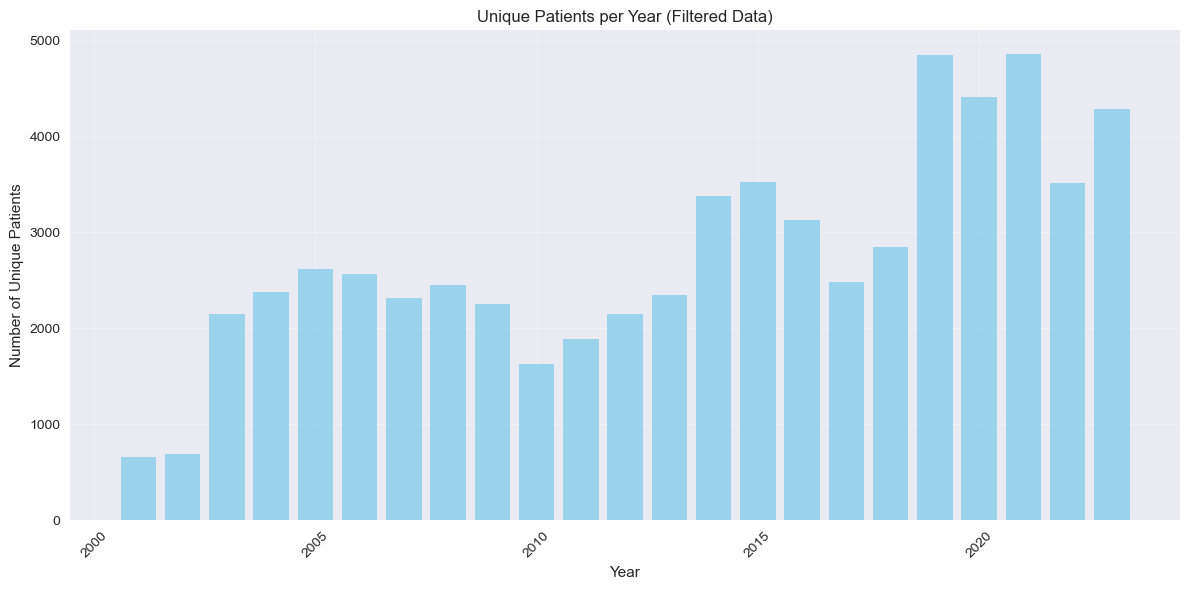

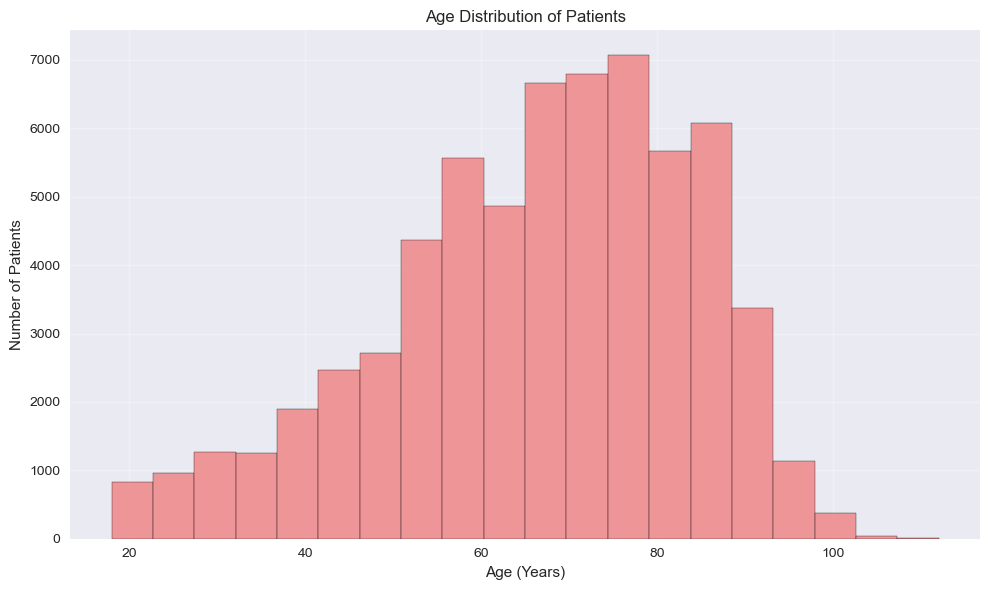

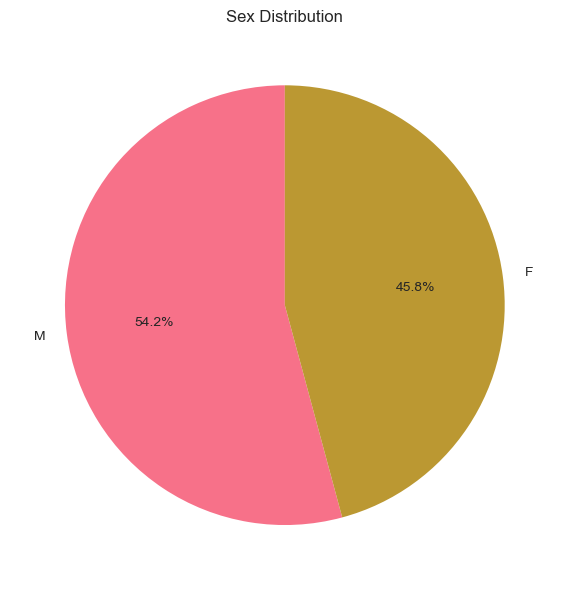

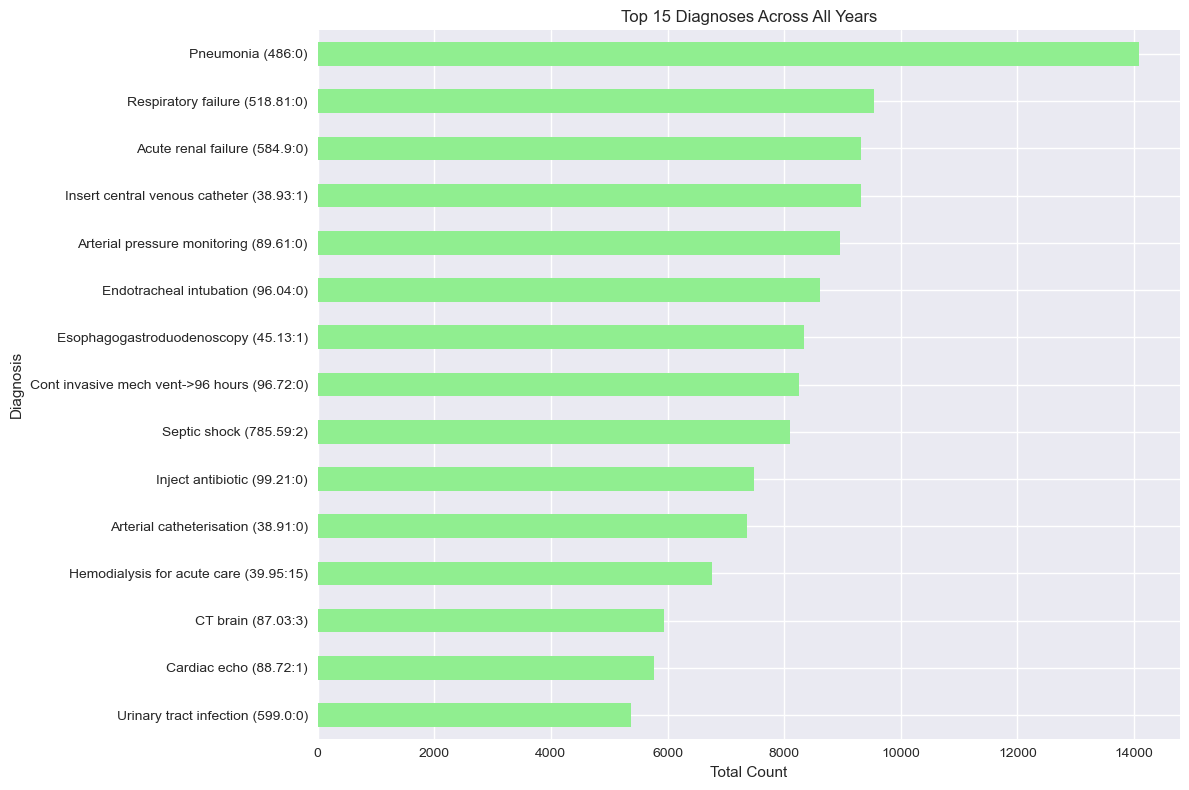

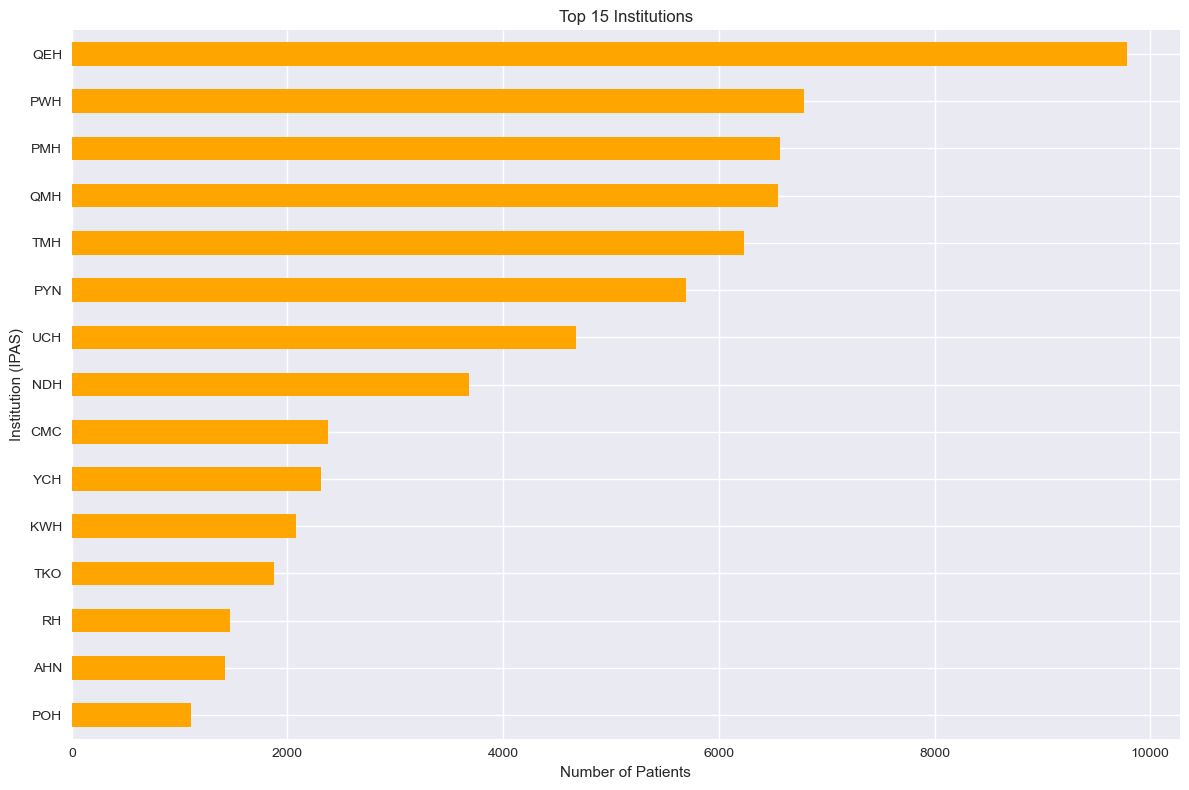

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_42800\4280865491.py:393: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_42800\4280865491.py:393: UserWarning: Glyph 25343 (\N{CJK UNIFIED IDEOGRAPH-62FF}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_42800\4280865491.py:393: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_42800\4280865491.py:393: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_42800\4280865491.py:393: UserWarning: Glyph 38867 (\N{CJK UNIFIED IDEOGRAPH-97D3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_42800\4280865491.py:393: Use

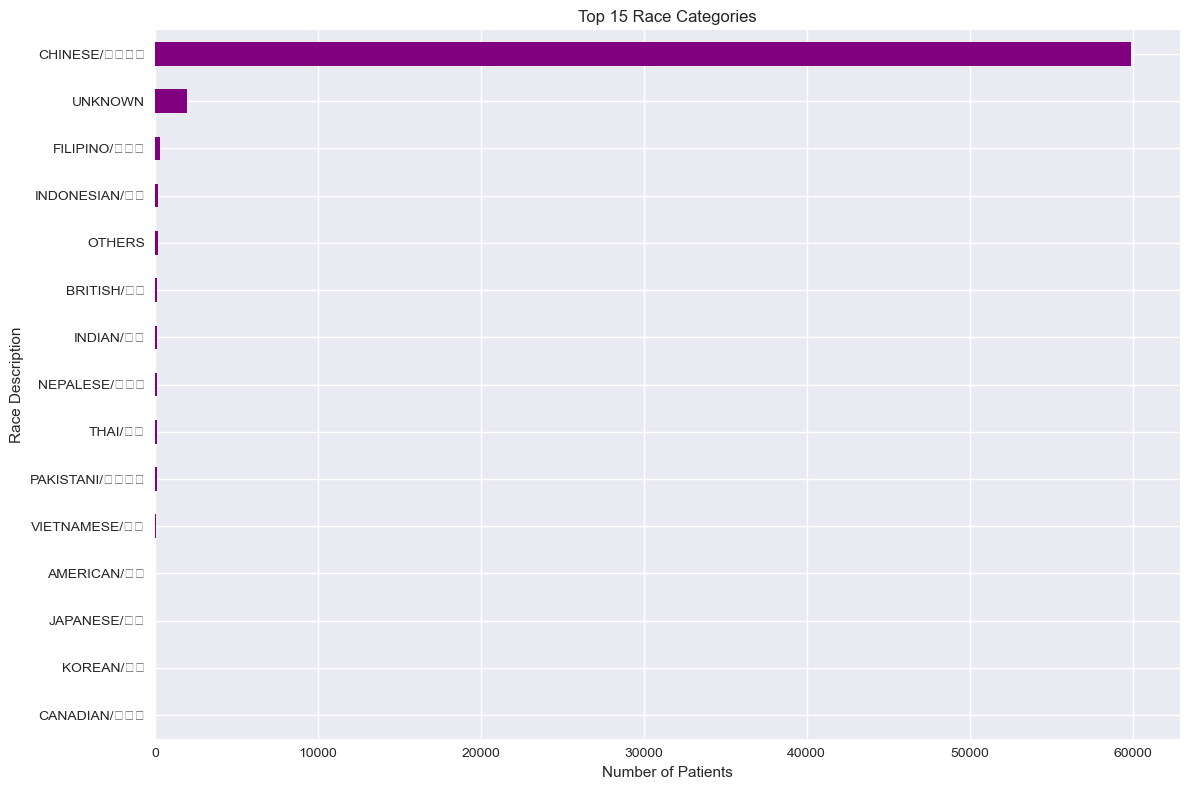

<Figure size 1200x600 with 0 Axes>

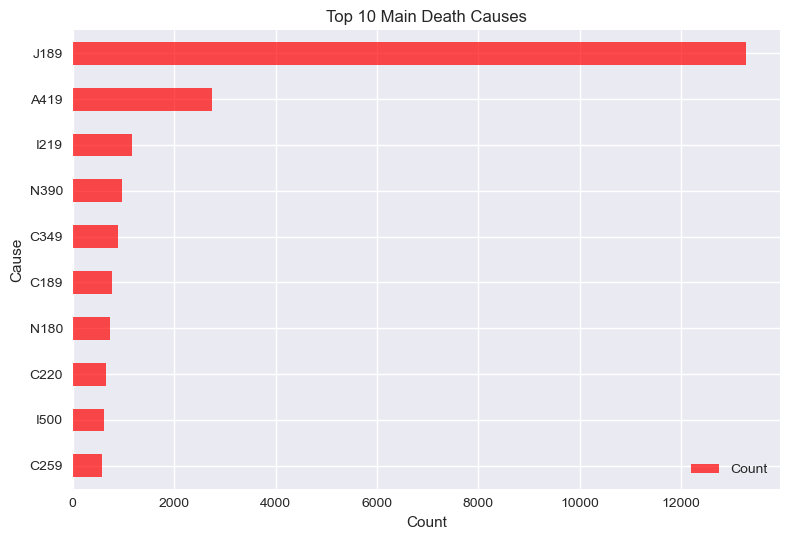

<Figure size 1200x600 with 0 Axes>

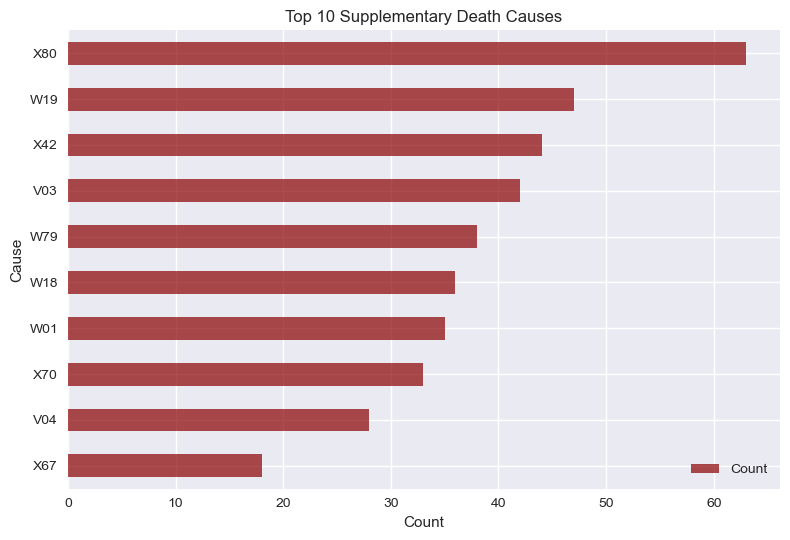

✓ Demographic summary saved to: ./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/demographic_summary_unique.csv

✅ Analysis complete! All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from collections import Counter

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_demographic_data():
    """Load the filtered demographic data"""
    input_file = "./Sepsis_plt/demographic/filtered_approved_hn/demographic_ALL_YEARS_filtered.csv"
    
    if not os.path.exists(input_file):
        print(f"Error: Filtered demographic file not found at {input_file}")
        return None
    
    print("Loading demographic data...")
    try:
        df = pd.read_csv(input_file)
        print(f"✓ Loaded {len(df):,} rows from demographic data")
        return df
    except Exception as e:
        print(f"✗ Error loading demographic data: {e}")
        return None

def get_unique_patients(df):
    """Get unique patients by Reference Key"""
    if 'Reference Key' not in df.columns:
        return df
    return df.drop_duplicates(subset=['Reference Key'])

def basic_demographic_analysis(df):
    """Perform basic demographic analysis using unique patients only"""
    print("\n" + "="*60)
    print("BASIC DEMOGRAPHIC ANALYSIS (UNIQUE PATIENTS ONLY)")
    print("="*60)
    
    # Get unique patients
    unique_df = get_unique_patients(df)
    
    # Count unique patients
    unique_patients = len(unique_df)
    total_records = len(df)
    print(f"Unique patients (Reference Key): {unique_patients:,}")
    print(f"Total diagnosis records: {total_records:,}")
    print(f"Average diagnoses per patient: {total_records/unique_patients:.2f}")
    
    # Year distribution of unique patients
    if 'Year' in df.columns:
        print(f"\nYear distribution (unique patients):")
        year_unique_counts = unique_df['Year'].value_counts().sort_index()
        for year, count in year_unique_counts.items():
            print(f"  {year}: {count:,} unique patients")
    
    # Sex distribution - using unique patients only
    if 'Sex' in df.columns:
        print(f"\nSex distribution (unique patients):")
        sex_counts = unique_df['Sex'].value_counts()
        for sex, count in sex_counts.items():
            percentage = count / len(unique_df) * 100
            print(f"  {sex}: {count:,} ({percentage:.1f}%)")
    
    # Age distribution - using unique patients only
    if 'Admission Age (Year) (episode based)' in df.columns:
        age_col = 'Admission Age (Year) (episode based)'
        age_data = unique_df[age_col].dropna()
        if len(age_data) > 0:
            print(f"\nAge distribution (unique patients):")
            print(f"  Min age: {age_data.min():.1f}")
            print(f"  Max age: {age_data.max():.1f}")
            print(f"  Mean age: {age_data.mean():.1f}")
            print(f"  Median age: {age_data.median():.1f}")
            
            # Age groups
            bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 120]
            labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91+']
            age_groups = pd.cut(age_data, bins=bins, labels=labels, right=False)
            age_group_counts = age_groups.value_counts().sort_index()
            print(f"\nAge groups (unique patients):")
            for group, count in age_group_counts.items():
                percentage = count / len(age_data) * 100
                print(f"  {group}: {count:,} ({percentage:.1f}%)")
    
    # Mortality analysis - using unique patients only
    if 'Episode Death (Y/N)' in df.columns:
        print(f"\nMortality analysis (unique patients):")
        death_counts = unique_df['Episode Death (Y/N)'].value_counts()
        total_unique = len(unique_df)
        for status, count in death_counts.items():
            percentage = count / total_unique * 100
            print(f"  {status}: {count:,} ({percentage:.1f}%)")
    
    # Race distribution - using unique patients only
    if 'Race Description' in df.columns:
        print(f"\nTop 10 race categories (unique patients):")
        race_counts = unique_df['Race Description'].value_counts().head(10)
        for race, count in race_counts.items():
            percentage = count / len(unique_df) * 100
            print(f"  {race}: {count:,} ({percentage:.1f}%)")

def analyze_institution(df):
    """Analyze institution distribution using unique patients only"""
    if 'Institution (IPAS)' not in df.columns:
        print("✗ 'Institution (IPAS)' column not found")
        return
    
    print("\n" + "="*60)
    print("INSTITUTION ANALYSIS (UNIQUE PATIENTS ONLY)")
    print("="*60)
    
    # Get unique patients
    unique_df = get_unique_patients(df)
    
    institution_counts = unique_df['Institution (IPAS)'].value_counts()
    total_unique = len(unique_df)
    
    print(f"Total institutions: {len(institution_counts)}")
    print(f"\nTop 15 institutions:")
    for i, (institution, count) in enumerate(institution_counts.head(15).items(), 1):
        percentage = count / total_unique * 100
        print(f"  {i:2d}. {institution}: {count:,} ({percentage:.1f}%)")
    
    # Save institution data
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    institution_df = pd.DataFrame({
        'Institution': institution_counts.index,
        'Count': institution_counts.values,
        'Percentage': (institution_counts.values / total_unique * 100)
    })
    institution_file = os.path.join(output_folder, "institution_distribution_unique.csv")
    institution_df.to_csv(institution_file, index=False)
    print(f"✓ Institution distribution saved to: {institution_file}")
    
    return institution_counts

def analyze_race(df):
    """Analyze race distribution in detail using unique patients only"""
    if 'Race Description' not in df.columns:
        print("✗ 'Race Description' column not found")
        return
    
    print("\n" + "="*60)
    print("RACE ANALYSIS (UNIQUE PATIENTS ONLY)")
    print("="*60)
    
    # Get unique patients
    unique_df = get_unique_patients(df)
    
    race_counts = unique_df['Race Description'].value_counts()
    total_unique = len(unique_df)
    
    print(f"Total race categories: {len(race_counts)}")
    print(f"\nComplete race distribution (unique patients):")
    for i, (race, count) in enumerate(race_counts.items(), 1):
        percentage = count / total_unique * 100
        print(f"  {i:2d}. {race}: {count:,} ({percentage:.1f}%)")
    
    # Save race data
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    race_df = pd.DataFrame({
        'Race': race_counts.index,
        'Count': race_counts.values,
        'Percentage': (race_counts.values / total_unique * 100)
    })
    race_file = os.path.join(output_folder, "race_distribution_unique.csv")
    race_df.to_csv(race_file, index=False)
    print(f"✓ Race distribution saved to: {race_file}")
    
    return race_counts

def analyze_death_causes(df):
    """Analyze death causes and mortality patterns using unique patients only"""
    print("\n" + "="*60)
    print("DEATH CAUSE ANALYSIS (UNIQUE PATIENTS ONLY)")
    print("="*60)
    
    # Get unique patients
    unique_df = get_unique_patients(df)
    
    # Basic mortality statistics
    if 'Episode Death (Y/N)' in df.columns:
        death_patients = unique_df[unique_df['Episode Death (Y/N)'] == 'Y']
        total_unique = len(unique_df)
        death_count = len(death_patients)
        
        print(f"Unique patients with death: {death_count:,}")
        print(f"Overall mortality rate: {death_count/total_unique*100:.2f}%")
    
    # Death causes analysis - using unique patients only
    death_causes_data = []
    
    # Main death cause
    if 'Death Cause (Main Cause)' in df.columns:
        main_causes = unique_df['Death Cause (Main Cause)'].dropna()
        if len(main_causes) > 0:
            main_cause_counts = main_causes.value_counts()
            print(f"\nTop 15 Main Death Causes (unique patients):")
            for i, (cause, count) in enumerate(main_cause_counts.head(15).items(), 1):
                percentage = count / len(main_causes) * 100
                print(f"  {i:2d}. {cause}: {count:,} ({percentage:.1f}%)")
                death_causes_data.append({
                    'Cause_Type': 'Main_Cause',
                    'Cause': cause,
                    'Count': count,
                    'Percentage': percentage
                })
    
    # Supplementary death cause
    if 'Death Cause (Supplementary Cause)' in df.columns:
        supp_causes = unique_df['Death Cause (Supplementary Cause)'].dropna()
        if len(supp_causes) > 0:
            supp_cause_counts = supp_causes.value_counts()
            print(f"\nTop 15 Supplementary Death Causes (unique patients):")
            for i, (cause, count) in enumerate(supp_cause_counts.head(15).items(), 1):
                percentage = count / len(supp_causes) * 100
                print(f"  {i:2d}. {cause}: {count:,} ({percentage:.1f}%)")
                death_causes_data.append({
                    'Cause_Type': 'Supplementary_Cause',
                    'Cause': cause,
                    'Count': count,
                    'Percentage': percentage
                })
    
    # Death date analysis - using unique patients only
    if 'Date of Registered Death' in df.columns:
        death_dates = unique_df['Date of Registered Death'].dropna()
        if len(death_dates) > 0:
            print(f"\nDeath date analysis (unique patients):")
            print(f"  Unique patients with death date: {len(death_dates):,}")
            
            # Convert to datetime if possible
            try:
                death_dates_dt = pd.to_datetime(death_dates, errors='coerce')
                death_dates_dt = death_dates_dt.dropna()
                if len(death_dates_dt) > 0:
                    print(f"  Earliest death: {death_dates_dt.min().strftime('%Y-%m-%d')}")
                    print(f"  Latest death: {death_dates_dt.max().strftime('%Y-%m-%d')}")
                    
                    # Deaths by year
                    deaths_by_year = death_dates_dt.dt.year.value_counts().sort_index()
                    print(f"\n  Deaths by year (unique patients):")
                    for year, count in deaths_by_year.items():
                        print(f"    {year}: {count:,}")
            except:
                print(f"  Could not parse death dates")
    
    # Save death causes data
    if death_causes_data:
        output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/"
        os.makedirs(output_folder, exist_ok=True)
        
        death_causes_df = pd.DataFrame(death_causes_data)
        death_causes_file = os.path.join(output_folder, "death_causes_analysis_unique.csv")
        death_causes_df.to_csv(death_causes_file, index=False)
        print(f"✓ Death causes analysis saved to: {death_causes_file}")
    
    return death_causes_data

def diagnosis_analysis_by_year(df):
    """Analyze top diagnoses by year (using all records since patients can have multiple diagnoses)"""
    if 'Dx/Px Description (HAMDCT)' not in df.columns or 'Year' not in df.columns:
        print("✗ Required columns for diagnosis analysis not found")
        return
    
    print("\n" + "="*60)
    print("DIAGNOSIS ANALYSIS BY YEAR (ALL RECORDS)")
    print("="*60)
    
    # Get all unique years
    years = sorted(df['Year'].unique())
    
    # Create output folder for diagnosis reports
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    all_year_diagnoses = []
    
    for year in years:
        year_data = df[df['Year'] == year]
        diagnoses = year_data['Dx/Px Description (HAMDCT)'].dropna()
        
        if len(diagnoses) > 0:
            # Get top 20 diagnoses for this year
            diagnosis_counts = Counter(diagnoses)
            top_20 = diagnosis_counts.most_common(20)
            
            print(f"\nYear {year}: Top 20 Diagnoses")
            print("-" * 40)
            
            year_diagnoses = []
            for i, (diagnosis, count) in enumerate(top_20, 1):
                percentage = count / len(diagnoses) * 100
                print(f"  {i:2d}. {diagnosis}: {count:,} ({percentage:.1f}%)")
                year_diagnoses.append({
                    'Year': year,
                    'Rank': i,
                    'Diagnosis': diagnosis,
                    'Count': count,
                    'Percentage': percentage
                })
            
            all_year_diagnoses.extend(year_diagnoses)
    
    # Save detailed diagnosis data
    if all_year_diagnoses:
        diagnosis_df = pd.DataFrame(all_year_diagnoses)
        diagnosis_file = os.path.join(output_folder, "top_diagnoses_by_year.csv")
        diagnosis_df.to_csv(diagnosis_file, index=False)
        print(f"\n✓ Detailed diagnosis data saved to: {diagnosis_file}")
    
    return all_year_diagnoses

def create_demographic_plots(df, diagnosis_data, institution_counts, race_counts, death_causes_data):
    """Create visualizations for demographic data using unique patients only"""
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    # Get unique patients for demographic plots
    unique_df = get_unique_patients(df)
    
    # Plot 1: Unique patients per year
    plt.figure(figsize=(12, 6))
    year_counts = unique_df['Year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values, alpha=0.8, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of Unique Patients')
    plt.title('Unique Patients per Year (Filtered Data)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'unique_patients_per_year.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Age distribution (unique patients)
    if 'Admission Age (Year) (episode based)' in df.columns:
        plt.figure(figsize=(10, 6))
        age_data = unique_df['Admission Age (Year) (episode based)'].dropna()
        plt.hist(age_data, bins=20, alpha=0.8, color='lightcoral', edgecolor='black')
        plt.xlabel('Age (Years)')
        plt.ylabel('Number of Patients')
        plt.title('Age Distribution of Patients')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, 'age_distribution_unique.png'), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot 3: Sex distribution (unique patients)
    if 'Sex' in df.columns:
        plt.figure(figsize=(8, 6))
        sex_counts = unique_df['Sex'].value_counts()
        plt.pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title('Sex Distribution')
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, 'sex_distribution_unique.png'), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot 4: Top diagnoses across all years (all records)
    if diagnosis_data:
        diagnosis_df = pd.DataFrame(diagnosis_data)
        top_diagnoses_all = diagnosis_df.groupby('Diagnosis')['Count'].sum().sort_values(ascending=False).head(15)
        
        plt.figure(figsize=(12, 8))
        top_diagnoses_all.sort_values().plot(kind='barh', color='lightgreen')
        plt.xlabel('Total Count')
        plt.title('Top 15 Diagnoses Across All Years')
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, 'top_diagnoses_all_years.png'), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot 5: Institution distribution (top 15) - unique patients
    if institution_counts is not None:
        plt.figure(figsize=(12, 8))
        institution_counts.head(15).sort_values().plot(kind='barh', color='orange')
        plt.xlabel('Number of Patients')
        plt.title('Top 15 Institutions')
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, 'institution_distribution_unique.png'), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot 6: Race distribution (top 15) - unique patients
    if race_counts is not None:
        plt.figure(figsize=(12, 8))
        race_counts.head(15).sort_values().plot(kind='barh', color='purple')
        plt.xlabel('Number of Patients')
        plt.title('Top 15 Race Categories')
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, 'race_distribution_unique.png'), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot 7: Death causes - unique patients
    if death_causes_data:
        death_causes_df = pd.DataFrame(death_causes_data)
        
        # Main causes
        main_causes = death_causes_df[death_causes_df['Cause_Type'] == 'Main_Cause'].head(10)
        if len(main_causes) > 0:
            plt.figure(figsize=(12, 6))
            main_causes.sort_values('Count').plot(kind='barh', x='Cause', y='Count', color='red', alpha=0.7)
            plt.xlabel('Count')
            plt.title('Top 10 Main Death Causes')
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, 'main_death_causes_unique.png'), dpi=150, bbox_inches='tight')
            plt.show()
        
        # Supplementary causes
        supp_causes = death_causes_df[death_causes_df['Cause_Type'] == 'Supplementary_Cause'].head(10)
        if len(supp_causes) > 0:
            plt.figure(figsize=(12, 6))
            supp_causes.sort_values('Count').plot(kind='barh', x='Cause', y='Count', color='darkred', alpha=0.7)
            plt.xlabel('Count')
            plt.title('Top 10 Supplementary Death Causes')
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, 'supplementary_death_causes_unique.png'), dpi=150, bbox_inches='tight')
            plt.show()

def save_demographic_summary(df):
    """Save comprehensive demographic summary using unique patients only"""
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    # Get unique patients
    unique_df = get_unique_patients(df)
    
    summary_data = []
    
    # Basic counts
    summary_data.append({'Metric': 'Unique Patients', 'Value': len(unique_df)})
    summary_data.append({'Metric': 'Total Records', 'Value': len(df)})
    
    # Year range
    if 'Year' in df.columns:
        min_year = df['Year'].min()
        max_year = df['Year'].max()
        summary_data.append({'Metric': 'Year Range', 'Value': f"{min_year}-{max_year}"})
    
    # Sex distribution
    if 'Sex' in df.columns:
        sex_counts = unique_df['Sex'].value_counts()
        for sex, count in sex_counts.items():
            summary_data.append({'Metric': f"Sex - {sex}", 'Value': count})
    
    # Age statistics
    if 'Admission Age (Year) (episode based)' in df.columns:
        age_data = unique_df['Admission Age (Year) (episode based)'].dropna()
        if len(age_data) > 0:
            summary_data.append({'Metric': 'Mean Age', 'Value': f"{age_data.mean():.1f}"})
            summary_data.append({'Metric': 'Median Age', 'Value': f"{age_data.median():.1f}"})
            summary_data.append({'Metric': 'Min Age', 'Value': f"{age_data.min():.1f}"})
            summary_data.append({'Metric': 'Max Age', 'Value': f"{age_data.max():.1f}"})
    
    # Mortality
    if 'Episode Death (Y/N)' in df.columns:
        death_counts = unique_df['Episode Death (Y/N)'].value_counts()
        for status, count in death_counts.items():
            summary_data.append({'Metric': f"Mortality - {status}", 'Value': count})
    
    # Save summary
    summary_df = pd.DataFrame(summary_data)
    summary_file = os.path.join(output_folder, "demographic_summary_unique.csv")
    summary_df.to_csv(summary_file, index=False)
    print(f"✓ Demographic summary saved to: {summary_file}")

def main():
    """Main function for demographic analysis"""
    print("Performing demographic analysis on filtered data (unique patients only)...")
    
    # Load data
    df = load_demographic_data()
    if df is None:
        return
    
    # Perform analyses
    basic_demographic_analysis(df)
    diagnosis_data = diagnosis_analysis_by_year(df)
    institution_counts = analyze_institution(df)
    race_counts = analyze_race(df)
    death_causes_data = analyze_death_causes(df)
    
    # Create visualizations
    create_demographic_plots(df, diagnosis_data, institution_counts, race_counts, death_causes_data)
    
    # Save summary
    save_demographic_summary(df)
    
    print(f"\n✅ Analysis complete! All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/diagnosis_analysis/")

if __name__ == "__main__":
    main()

Analyzing age distribution (patients counted separately for each year)...
Loading demographic data...
✓ Loaded 692,541 rows from demographic data

READMISSION PATTERN ANALYSIS
Total unique patients: 63,421
Patients with single admission: 61,379 (96.8%)
Patients with multiple admissions: 2,042 (3.2%)

Distribution of admissions per patient:
  1 admission(s): 61,379 patients (96.8%)
  2 admission(s): 1,905 patients (3.0%)
  3 admission(s): 116 patients (0.2%)
  4 admission(s): 17 patients (0.0%)
  5 admission(s): 2 patients (0.0%)
  6 admission(s): 2 patients (0.0%)
✓ Readmission patterns saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/readmission_patterns.csv

Available years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Select analysis option:
1. Analyze specific year
2. Analyze all years (patients counted per year)
3. Compare multiple years (patients counted per year)

A

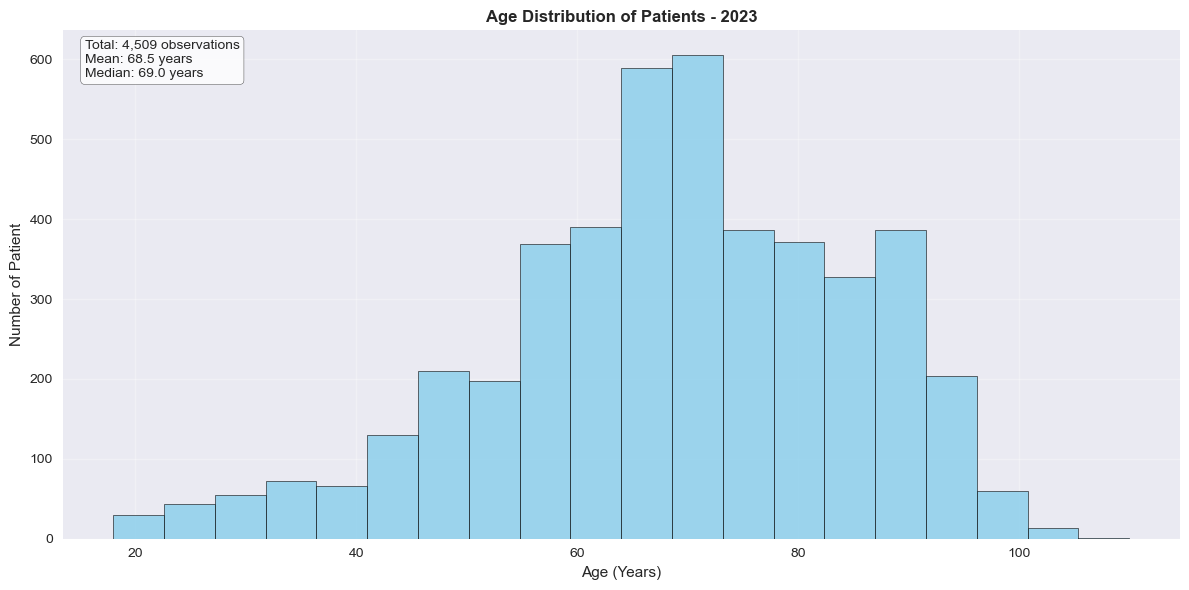

✓ Age summary saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/age_summary_2023.csv
✓ Age groups distribution saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/age_groups_2023.csv

✅ Age analysis complete! All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_demographic_data():
    """Load the filtered demographic data"""
    input_file = "./Sepsis_plt/demographic/filtered_approved_hn/demographic_ALL_YEARS_filtered.csv"
    
    if not os.path.exists(input_file):
        print(f"Error: Filtered demographic file not found at {input_file}")
        return None
    
    print("Loading demographic data...")
    try:
        df = pd.read_csv(input_file)
        print(f"✓ Loaded {len(df):,} rows from demographic data")
        return df
    except Exception as e:
        print(f"✗ Error loading demographic data: {e}")
        return None

def get_unique_patients_by_year(df):
    """Get unique patients by Reference Key AND Year (same patient in different years counts separately)"""
    if 'Reference Key' not in df.columns or 'Year' not in df.columns:
        return df
    return df.drop_duplicates(subset=['Reference Key', 'Year'])

def get_available_years(df):
    """Get list of available years in the data"""
    if 'Year' not in df.columns:
        return []
    return sorted(df['Year'].unique())

def analyze_age_distribution_by_year(df, year=None):
    """Analyze age distribution for a specific year or all years"""
    
    # Get unique patients by year (same patient in different years counts separately)
    unique_df = get_unique_patients_by_year(df)
    
    if year:
        # Filter for specific year
        year_data = unique_df[unique_df['Year'] == year]
        print(f"\n" + "="*60)
        print(f"AGE DISTRIBUTION ANALYSIS FOR {year}")
        print("="*60)
    else:
        # Use all data (patients can appear multiple times if in different years)
        year_data = unique_df
        print(f"\n" + "="*60)
        print("AGE DISTRIBUTION ANALYSIS (ALL YEARS - PATIENTS COUNTED PER YEAR)")
        print("="*60)
    
    if 'Admission Age (Year) (episode based)' not in year_data.columns:
        print("✗ 'Admission Age (Year) (episode based)' column not found")
        return None
    
    age_data = year_data['Admission Age (Year) (episode based)'].dropna()
    
    if len(age_data) == 0:
        print(f"✗ No age data available for {year if year else 'all years'}")
        return None
    
    # Count unique patients (across all years, for reference)
    total_unique_patients_all_years = df['Reference Key'].nunique()
    
    print(f"Total patient-year observations with age data: {len(age_data):,}")
    print(f"Total unique patients across all years: {total_unique_patients_all_years:,}")
    print(f"Age range: {age_data.min():.1f} - {age_data.max():.1f} years")
    print(f"Mean age: {age_data.mean():.1f} years")
    print(f"Median age: {age_data.median():.1f} years")
    print(f"Standard deviation: {age_data.std():.1f} years")
    
    return age_data

def create_age_groups(age_data):
    """Create age groups and return counts (starting from 19-30)"""
    # Define age groups starting from 19-30
    bins = [17, 30, 40, 50, 60, 70, 80, 90, 120]
    labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91+']
    
    age_groups = pd.cut(age_data, bins=bins, labels=labels, right=False)
    age_group_counts = age_groups.value_counts().sort_index()
    
    return age_group_counts, labels

def plot_age_distribution(age_data, year=None):
    """Create age distribution histogram"""
    plt.figure(figsize=(12, 6))
    
    # Create histogram
    n, bins, patches = plt.hist(age_data, bins=20, alpha=0.8, color='skyblue', edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Age (Years)')
    plt.ylabel('Number of Patient')
    title = f'Age Distribution of Patients'
    if year:
        title += f' - {year}'
    else:
        title += ''
    plt.title(title, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add statistics box
    stats_text = f'Total: {len(age_data):,} observations\nMean: {age_data.mean():.1f} years\nMedian: {age_data.median():.1f} years'
    plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    
    # Save plot
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    filename = f"age_distribution_{year}.png" if year else "age_distribution_all_years_counted_per_year.png"
    plt.savefig(os.path.join(output_folder, filename), dpi=150, bbox_inches='tight')
    plt.show()

def plot_age_groups_stacked_bar(df, years=None):
    """Create stacked bar chart of age groups across years (patients counted per year)"""
    
    if years is None:
        # Use all available years
        years = get_available_years(df)
    
    # Get unique patients by year
    unique_df = get_unique_patients_by_year(df)
    
    # Prepare data for stacked bar chart
    age_group_data = []
    
    for year in years:
        year_data = unique_df[unique_df['Year'] == year]
        age_data = year_data['Admission Age (Year) (episode based)'].dropna()
        
        if len(age_data) > 0:
            age_group_counts, labels = create_age_groups(age_data)
            
            year_data_dict = {'Year': year, 'Total': len(age_data)}
            for label in labels:
                year_data_dict[label] = age_group_counts.get(label, 0)
            
            age_group_data.append(year_data_dict)
    
    if not age_group_data:
        print("✗ No age data available for the selected years")
        return
    
    # Create DataFrame
    age_df = pd.DataFrame(age_group_data)
    
    # Plot stacked bar chart
    plt.figure(figsize=(14, 8))
    
    # Get age group columns (excluding Year and Total)
    age_group_cols = [col for col in age_df.columns if col not in ['Year', 'Total']]
    
    # Create stacked bars
    bottom = np.zeros(len(age_df))
    colors = plt.cm.Set3(np.linspace(0, 1, len(age_group_cols)))
    
    for i, age_group in enumerate(age_group_cols):
        counts = age_df[age_group]
        plt.bar(age_df['Year'], counts, bottom=bottom, label=age_group, color=colors[i], alpha=0.8)
        bottom += counts
    
    plt.xlabel('Year')
    plt.ylabel('Number of Patient-Year Observations')
    plt.title('Age Group Distribution Across Years', fontweight='bold')
    plt.legend(title='Age Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    plt.savefig(os.path.join(output_folder, 'age_groups_stacked_bar_counted_per_year.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    return age_df

def plot_age_groups_percentage_stacked_bar(df, years=None):
    """Create percentage stacked bar chart of age groups across years (patients counted per year)"""
    
    if years is None:
        # Use all available years
        years = get_available_years(df)
    
    # Get unique patients by year
    unique_df = get_unique_patients_by_year(df)
    
    # Prepare data for percentage stacked bar chart
    age_group_data = []
    
    for year in years:
        year_data = unique_df[unique_df['Year'] == year]
        age_data = year_data['Admission Age (Year) (episode based)'].dropna()
        
        if len(age_data) > 0:
            age_group_counts, labels = create_age_groups(age_data)
            total = len(age_data)
            
            year_data_dict = {'Year': year, 'Total': total}
            for label in labels:
                count = age_group_counts.get(label, 0)
                percentage = (count / total * 100) if total > 0 else 0
                year_data_dict[label] = percentage
            
            age_group_data.append(year_data_dict)
    
    if not age_group_data:
        print("✗ No age data available for the selected years")
        return
    
    # Create DataFrame
    age_df = pd.DataFrame(age_group_data)
    
    # Plot percentage stacked bar chart
    plt.figure(figsize=(14, 8))
    
    # Get age group columns (excluding Year and Total)
    age_group_cols = [col for col in age_df.columns if col not in ['Year', 'Total']]
    
    # Create percentage stacked bars
    bottom = np.zeros(len(age_df))
    colors = plt.cm.Set3(np.linspace(0, 1, len(age_group_cols)))
    
    for i, age_group in enumerate(age_group_cols):
        percentages = age_df[age_group]
        plt.bar(age_df['Year'], percentages, bottom=bottom, label=age_group, color=colors[i], alpha=0.8)
        bottom += percentages
    
    plt.xlabel('Year')
    plt.ylabel('Percentage of Patient-Year Observations (%)')
    plt.title('Age Group Distribution Across Years (Percentage)', fontweight='bold')
    plt.legend(title='Age Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    # Add percentage labels on each segment (no threshold - show all percentages)
    for i, year in enumerate(age_df['Year']):
        current_bottom = 0
        for age_group in age_group_cols:
            percentage = age_df[age_group].iloc[i]
            if percentage > 0:  # Only label if percentage > 0
                plt.text(year, current_bottom + percentage/2, f'{percentage:.1f}%', 
                        ha='center', va='center', fontsize=8, fontweight='bold',
                        color='white' if percentage < 0 else 'black')
            current_bottom += percentage
    
    plt.tight_layout()
    
    # Save plot
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    plt.savefig(os.path.join(output_folder, 'age_groups_percentage_stacked_bar_counted_per_year.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    return age_df

def save_age_analysis_results(age_data, year=None):
    """Save age analysis results to CSV"""
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    # Create age groups
    age_group_counts, labels = create_age_groups(age_data)
    
    # Create summary statistics
    summary_data = {
        'Statistic': ['Total Patient-Year Observations', 'Mean Age', 'Median Age', 'Min Age', 'Max Age', 'Standard Deviation'],
        'Value': [len(age_data), age_data.mean(), age_data.median(), age_data.min(), age_data.max(), age_data.std()]
    }
    summary_df = pd.DataFrame(summary_data)
    
    # Create age group distribution
    age_group_df = pd.DataFrame({
        'Age Group': age_group_counts.index,
        'Count': age_group_counts.values,
        'Percentage': (age_group_counts.values / len(age_data) * 100)
    })
    
    # Save files
    if year:
        summary_file = os.path.join(output_folder, f"age_summary_{year}.csv")
        age_group_file = os.path.join(output_folder, f"age_groups_{year}.csv")
    else:
        summary_file = os.path.join(output_folder, "age_summary_all_years_counted_per_year.csv")
        age_group_file = os.path.join(output_folder, "age_groups_all_years_counted_per_year.csv")
    
    summary_df.to_csv(summary_file, index=False)
    age_group_df.to_csv(age_group_file, index=False)
    
    print(f"✓ Age summary saved to: {summary_file}")
    print(f"✓ Age groups distribution saved to: {age_group_file}")

def analyze_readmission_patterns(df):
    """Analyze how many patients are readmitted across different years"""
    print("\n" + "="*60)
    print("READMISSION PATTERN ANALYSIS")
    print("="*60)
    
    # Count admissions per patient
    admissions_per_patient = df.groupby('Reference Key')['Year'].nunique()
    
    single_admission = (admissions_per_patient == 1).sum()
    multiple_admissions = (admissions_per_patient > 1).sum()
    total_patients = len(admissions_per_patient)
    
    print(f"Total unique patients: {total_patients:,}")
    print(f"Patients with single admission: {single_admission:,} ({single_admission/total_patients*100:.1f}%)")
    print(f"Patients with multiple admissions: {multiple_admissions:,} ({multiple_admissions/total_patients*100:.1f}%)")
    
    # Distribution of number of admissions
    print(f"\nDistribution of admissions per patient:")
    admission_counts = admissions_per_patient.value_counts().sort_index()
    for count, patients in admission_counts.items():
        percentage = patients / total_patients * 100
        print(f"  {count} admission(s): {patients:,} patients ({percentage:.1f}%)")
    
    # Save readmission analysis
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    readmission_df = pd.DataFrame({
        'Admissions_Per_Patient': admission_counts.index,
        'Patient_Count': admission_counts.values,
        'Percentage': (admission_counts.values / total_patients * 100)
    })
    readmission_file = os.path.join(output_folder, "readmission_patterns.csv")
    readmission_df.to_csv(readmission_file, index=False)
    print(f"✓ Readmission patterns saved to: {readmission_file}")

def main():
    """Main function for age analysis"""
    print("Analyzing age distribution (patients counted separately for each year)...")
    
    # Load data
    df = load_demographic_data()
    if df is None:
        return
    
    # Analyze readmission patterns first
    analyze_readmission_patterns(df)
    
    # Get available years
    available_years = get_available_years(df)
    print(f"\nAvailable years: {available_years}")
    
    # Ask user for year selection
    print("\nSelect analysis option:")
    print("1. Analyze specific year")
    print("2. Analyze all years (patients counted per year)")
    print("3. Compare multiple years (patients counted per year)")
    
    choice = input("Enter your choice (1-3): ").strip()
    
    if choice == '1':
        # Analyze specific year
        year = int(input(f"Enter year to analyze ({available_years[0]}-{available_years[-1]}): "))
        if year not in available_years:
            print(f"✗ Year {year} not found in data")
            return
        
        age_data = analyze_age_distribution_by_year(df, year)
        if age_data is not None:
            plot_age_distribution(age_data, year)
            save_age_analysis_results(age_data, year)
    
    elif choice == '2':
        # Analyze all years combined (patients counted per year)
        age_data = analyze_age_distribution_by_year(df)
        if age_data is not None:
            plot_age_distribution(age_data)
            save_age_analysis_results(age_data)
    
    elif choice == '3':
        # Compare multiple years with stacked bar charts (patients counted per year)
        print(f"Available years: {available_years}")
        year_input = input("Enter years to compare (comma-separated, or 'all' for all years): ").strip()
        
        if year_input.lower() == 'all':
            years_to_compare = available_years
        else:
            try:
                years_to_compare = [int(y.strip()) for y in year_input.split(',')]
                # Validate years
                years_to_compare = [y for y in years_to_compare if y in available_years]
                if not years_to_compare:
                    print("✗ No valid years selected")
                    return
            except:
                print("✗ Invalid input format")
                return
        
        print(f"Comparing years: {years_to_compare}")
        
        # Create stacked bar charts
        age_df = plot_age_groups_stacked_bar(df, years_to_compare)
        percentage_df = plot_age_groups_percentage_stacked_bar(df, years_to_compare)
        
        if age_df is not None:
            # Save comparison data
            output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/"
            age_df.to_csv(os.path.join(output_folder, "age_groups_comparison_counted_per_year.csv"), index=False)
            percentage_df.to_csv(os.path.join(output_folder, "age_groups_percentage_comparison_counted_per_year.csv"), index=False)
            print(f"✓ Age group comparison data saved")
    
    else:
        print("✗ Invalid choice")
        return
    
    print(f"\n✅ Age analysis complete! All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_analysis/")

if __name__ == "__main__":
    main()

Analyzing mean and median age trends over years...
Loading demographic data...
✓ Loaded 692,541 rows from demographic data

AGE TREND STATISTICS BY YEAR
 Year  Mean_Age  Median_Age  Patient_Count  Min_Age  Max_Age  Std_Dev
 2001     61.60        67.0            661       19      100    17.64
 2002     64.89        70.0            688       18      104    19.43
 2003     64.75        69.0           2163       18      106    18.06
 2004     65.24        69.0           2414       18      103    17.79
 2005     65.41        69.0           2666       18      102    17.82
 2006     65.44        69.0           2628       18      107    17.52
 2007     64.55        68.0           2393       18      103    18.25
 2008     65.75        70.0           2516       18      104    18.28
 2009     65.97        70.0           2331       18      112    18.35
 2010     66.45        71.0           1694       18      103    18.89
 2011     65.56        68.0           1947       18      102    18.28
 2012  

<Figure size 1200x800 with 0 Axes>

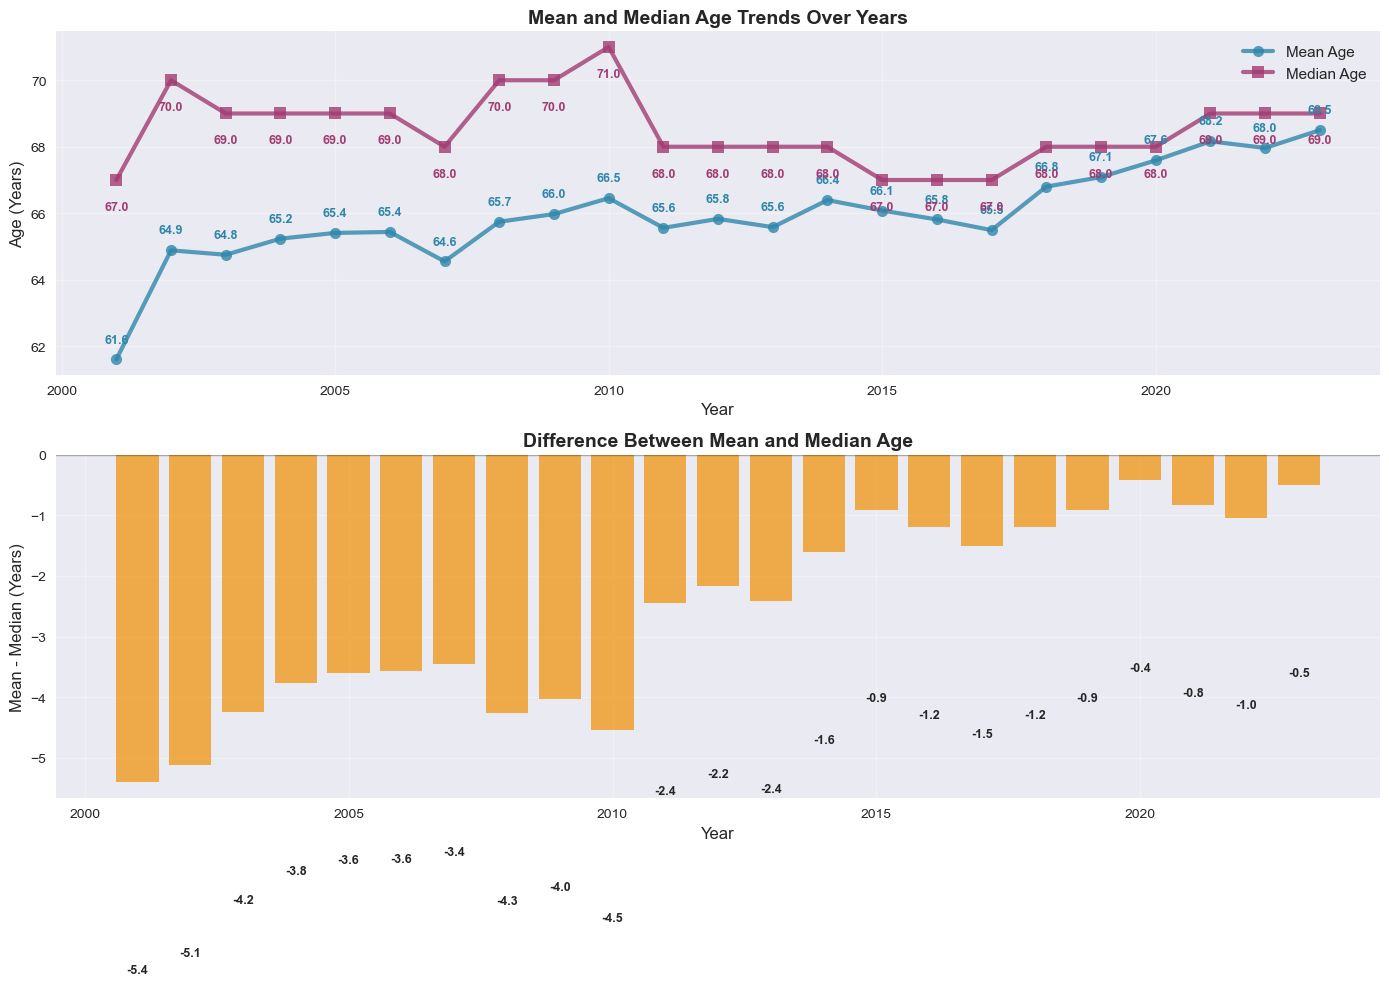

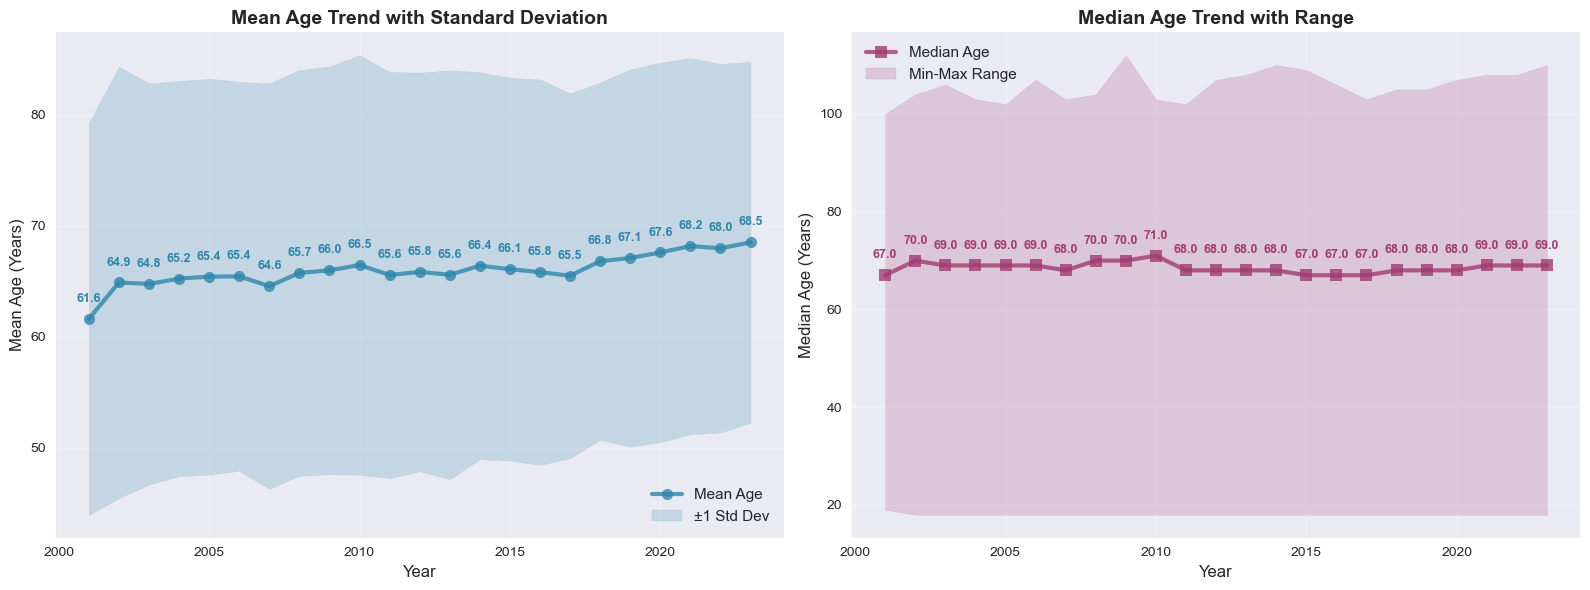

<Figure size 1400x1000 with 0 Axes>

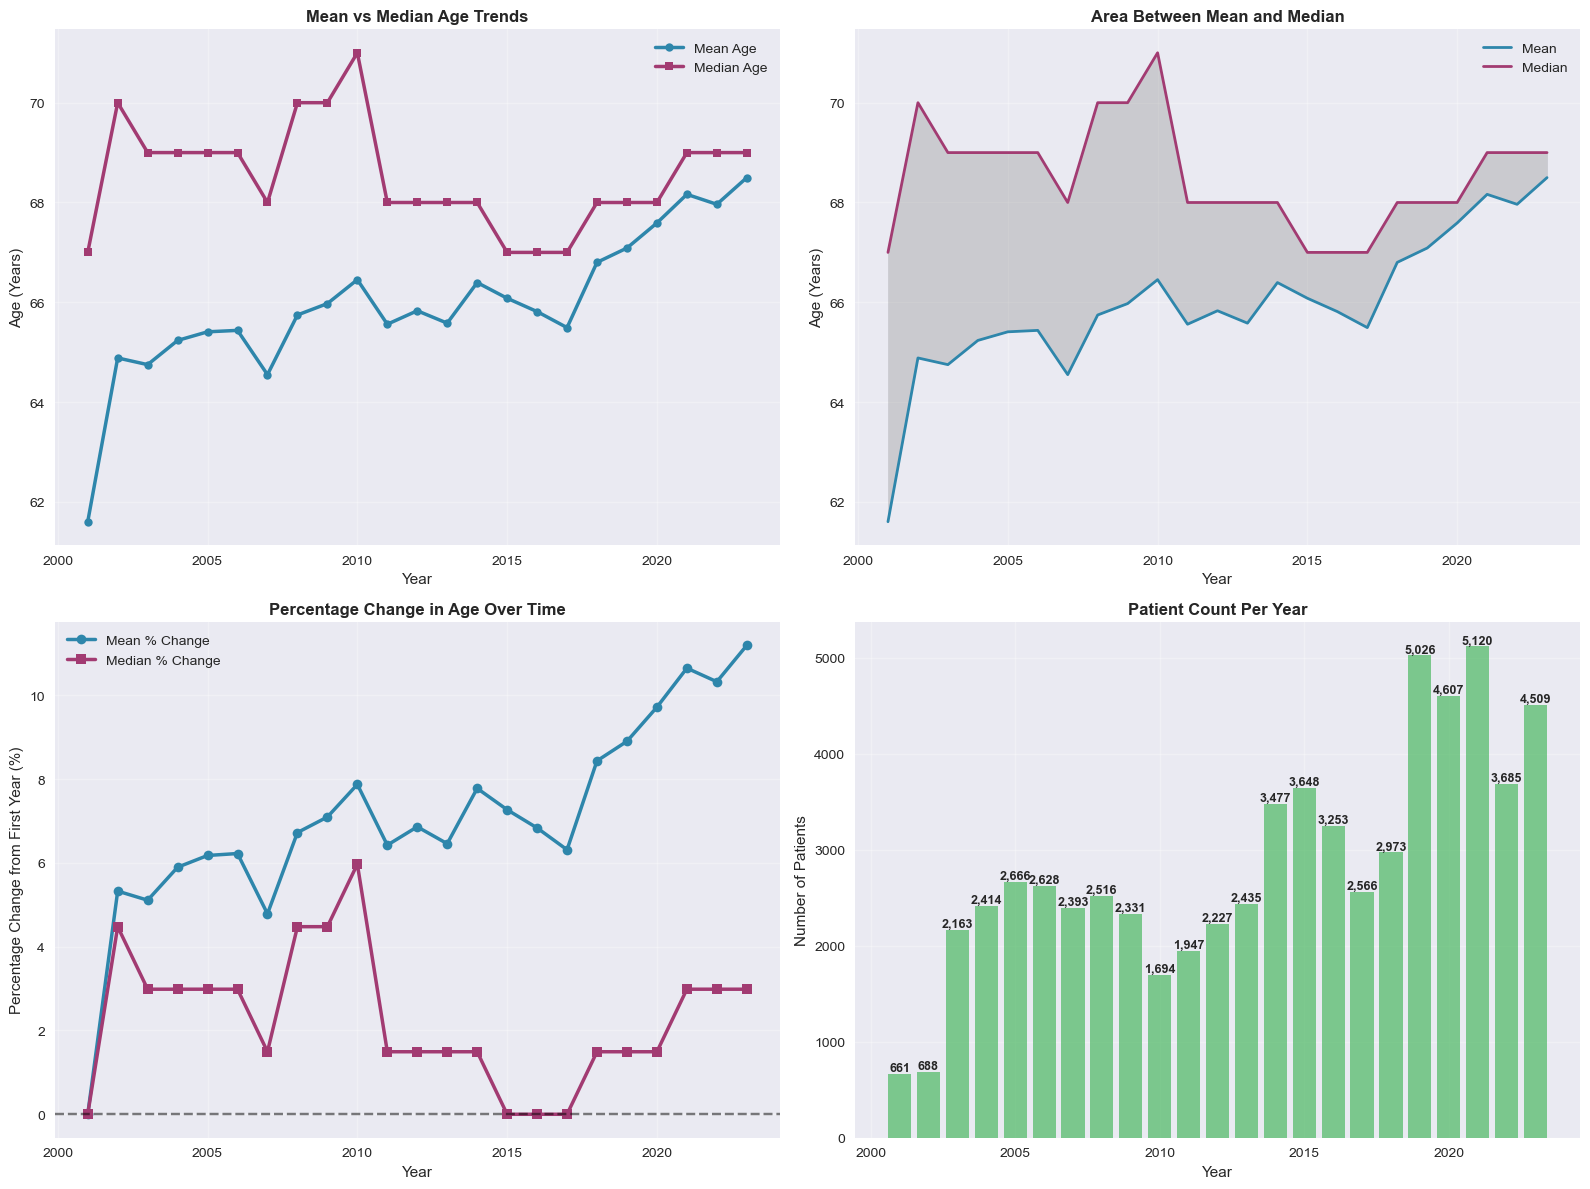

✓ Detailed trend statistics saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_trends/age_trend_statistics.csv
✓ Summary statistics saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_trends/age_trend_summary.csv

📊 KEY TREND INSIGHTS:
   Overall average age: 66.0 years
   Total change in mean age: +6.9 years
   Average yearly change: +0.31 years per year
   Correlation with time: 0.843

✅ Age trend analysis complete!
   All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_trends/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_demographic_data():
    """Load the filtered demographic data"""
    input_file = "./Sepsis_plt/demographic/filtered_approved_hn/demographic_ALL_YEARS_filtered.csv"
    
    if not os.path.exists(input_file):
        print(f"Error: Filtered demographic file not found at {input_file}")
        return None
    
    print("Loading demographic data...")
    try:
        df = pd.read_csv(input_file)
        print(f"✓ Loaded {len(df):,} rows from demographic data")
        return df
    except Exception as e:
        print(f"✗ Error loading demographic data: {e}")
        return None

def get_unique_patients_by_year(df):
    """Get unique patients by Reference Key AND Year (same patient in different years counts separately)"""
    if 'Reference Key' not in df.columns or 'Year' not in df.columns:
        return df
    return df.drop_duplicates(subset=['Reference Key', 'Year'])

def calculate_age_statistics_by_year(df):
    """Calculate mean and median age for each year"""
    if 'Admission Age (Year) (episode based)' not in df.columns or 'Year' not in df.columns:
        print("✗ Required columns not found")
        return None
    
    # Get unique patients by year
    unique_df = get_unique_patients_by_year(df)
    
    # Get available years
    years = sorted(unique_df['Year'].unique())
    
    age_stats = []
    
    for year in years:
        year_data = unique_df[unique_df['Year'] == year]
        age_data = year_data['Admission Age (Year) (episode based)'].dropna()
        
        if len(age_data) > 0:
            stats = {
                'Year': year,
                'Mean_Age': age_data.mean(),
                'Median_Age': age_data.median(),
                'Patient_Count': len(age_data),
                'Min_Age': age_data.min(),
                'Max_Age': age_data.max(),
                'Std_Dev': age_data.std()
            }
            age_stats.append(stats)
    
    if not age_stats:
        print("✗ No age data available")
        return None
    
    stats_df = pd.DataFrame(age_stats)
    return stats_df

def plot_mean_median_trend(stats_df):
    """Plot mean and median age trends over years"""
    plt.figure(figsize=(12, 8))
    
    # Create the main plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Mean and Median trends
    years = stats_df['Year']
    mean_ages = stats_df['Mean_Age']
    median_ages = stats_df['Median_Age']
    
    # Plot mean age trend
    line1 = ax1.plot(years, mean_ages, marker='o', linewidth=3, markersize=8, 
                    label='Mean Age', color='#2E86AB', alpha=0.8)
    
    # Plot median age trend
    line2 = ax1.plot(years, median_ages, marker='s', linewidth=3, markersize=8, 
                    label='Median Age', color='#A23B72', alpha=0.8)
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Age (Years)', fontsize=12)
    ax1.set_title('Mean and Median Age Trends Over Years', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    
    # Plot 2: Difference between mean and median
    difference = stats_df['Mean_Age'] - stats_df['Median_Age']
    
    bars = ax2.bar(years, difference, alpha=0.7, color='#F18F01')
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Mean - Median (Years)', fontsize=12)
    ax2.set_title('Difference Between Mean and Median Age', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    # Add value labels on bars
    for bar, diff in zip(bars, difference):
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        y_offset = 3 if height >= 0 else -3
        ax2.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                f'{diff:+.1f}', ha='center', va=va, fontsize=9, fontweight='bold')
    
    # Add zero reference line
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    plt.tight_layout()
    
    # Save plot
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_trends/"
    os.makedirs(output_folder, exist_ok=True)
    
    plt.savefig(os.path.join(output_folder, 'mean_median_age_trends.png'), dpi=150, bbox_inches='tight')
    plt.savefig(os.path.join(output_folder, 'mean_median_age_trends.pdf'), bbox_inches='tight')
    plt.show()
    
    return fig

def plot_individual_trends(stats_df):
    """Plot individual trends for mean and median with more details"""
    
    # Create individual plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    years = stats_df['Year']
    mean_ages = stats_df['Mean_Age']
    median_ages = stats_df['Median_Age']
    
    # Plot 1: Mean age trend with confidence interval (using std dev)
    ax1.plot(years, mean_ages, marker='o', linewidth=3, markersize=8, 
             color='#2E86AB', alpha=0.8, label='Mean Age')
    
    # Add standard deviation as shaded area
    std_dev = stats_df['Std_Dev']
    ax1.fill_between(years, mean_ages - std_dev, mean_ages + std_dev, 
                    alpha=0.2, color='#2E86AB', label='±1 Std Dev')
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Mean Age (Years)', fontsize=12)
    ax1.set_title('Mean Age Trend with Standard Deviation', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    
    # Add value labels for mean ages
    for i, (year, mean_age) in enumerate(zip(years, mean_ages)):
        ax1.annotate(f'{mean_age:.1f}', 
                    xy=(year, mean_age), 
                    xytext=(0, 10), 
                    textcoords='offset points',
                    ha='center', va='bottom', 
                    fontsize=9, fontweight='bold',
                    color='#2E86AB')
    
    # Plot 2: Median age trend with min/max range
    ax2.plot(years, median_ages, marker='s', linewidth=3, markersize=8, 
             color='#A23B72', alpha=0.8, label='Median Age')
    
    # Add min-max range as shaded area
    min_ages = stats_df['Min_Age']
    max_ages = stats_df['Max_Age']
    ax2.fill_between(years, min_ages, max_ages, 
                    alpha=0.2, color='#A23B72', label='Min-Max Range')
    
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Median Age (Years)', fontsize=12)
    ax2.set_title('Median Age Trend with Range', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    # Add value labels for median ages
    for i, (year, median_age) in enumerate(zip(years, median_ages)):
        ax2.annotate(f'{median_age:.1f}', 
                    xy=(year, median_age), 
                    xytext=(0, 10), 
                    textcoords='offset points',
                    ha='center', va='bottom', 
                    fontsize=9, fontweight='bold',
                    color='#A23B72')
    
    plt.tight_layout()
    
    # Save plot
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_trends/"
    os.makedirs(output_folder, exist_ok=True)
    
    plt.savefig(os.path.join(output_folder, 'individual_age_trends.png'), dpi=150, bbox_inches='tight')
    plt.savefig(os.path.join(output_folder, 'individual_age_trends.pdf'), bbox_inches='tight')
    plt.show()
    
    return fig

def plot_trend_comparison(stats_df):
    """Plot comprehensive comparison of age trends"""
    
    plt.figure(figsize=(14, 10))
    
    years = stats_df['Year']
    mean_ages = stats_df['Mean_Age']
    median_ages = stats_df['Median_Age']
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Simple trend lines
    ax1.plot(years, mean_ages, marker='o', linewidth=2.5, markersize=6, 
             color='#2E86AB', label='Mean Age')
    ax1.plot(years, median_ages, marker='s', linewidth=2.5, markersize=6, 
             color='#A23B72', label='Median Age')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Age (Years)')
    ax1.set_title('Mean vs Median Age Trends', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Area between mean and median
    ax2.fill_between(years, mean_ages, median_ages, alpha=0.3, color='gray')
    ax2.plot(years, mean_ages, color='#2E86AB', linewidth=2, label='Mean')
    ax2.plot(years, median_ages, color='#A23B72', linewidth=2, label='Median')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Age (Years)')
    ax2.set_title('Area Between Mean and Median', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Percentage change from first year
    first_year_mean = mean_ages.iloc[0]
    first_year_median = median_ages.iloc[0]
    
    mean_pct_change = ((mean_ages - first_year_mean) / first_year_mean) * 100
    median_pct_change = ((median_ages - first_year_median) / first_year_median) * 100
    
    ax3.plot(years, mean_pct_change, marker='o', linewidth=2.5, color='#2E86AB', label='Mean % Change')
    ax3.plot(years, median_pct_change, marker='s', linewidth=2.5, color='#A23B72', label='Median % Change')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Percentage Change from First Year (%)')
    ax3.set_title('Percentage Change in Age Over Time', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 4: Patient count per year
    patient_counts = stats_df['Patient_Count']
    bars = ax4.bar(years, patient_counts, alpha=0.7, color='#4CB963')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Number of Patients')
    ax4.set_title('Patient Count Per Year', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, patient_counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_trends/"
    os.makedirs(output_folder, exist_ok=True)
    
    plt.savefig(os.path.join(output_folder, 'comprehensive_age_trends.png'), dpi=150, bbox_inches='tight')
    plt.savefig(os.path.join(output_folder, 'comprehensive_age_trends.pdf'), bbox_inches='tight')
    plt.show()
    
    return fig

def save_trend_statistics(stats_df):
    """Save trend statistics to CSV"""
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/age_trends/"
    os.makedirs(output_folder, exist_ok=True)
    
    # Calculate additional statistics
    stats_df['Mean_Median_Difference'] = stats_df['Mean_Age'] - stats_df['Median_Age']
    stats_df['Yearly_Change_Mean'] = stats_df['Mean_Age'].diff()
    stats_df['Yearly_Change_Median'] = stats_df['Median_Age'].diff()
    stats_df['Cumulative_Change_Mean'] = stats_df['Mean_Age'] - stats_df['Mean_Age'].iloc[0]
    stats_df['Cumulative_Change_Median'] = stats_df['Median_Age'] - stats_df['Median_Age'].iloc[0]
    
    # Save detailed statistics
    stats_file = os.path.join(output_folder, "age_trend_statistics.csv")
    stats_df.to_csv(stats_file, index=False)
    
    # Create summary statistics
    summary_data = {
        'Metric': [
            'Overall Mean Age',
            'Overall Median Age', 
            'Average Yearly Change (Mean)',
            'Average Yearly Change (Median)',
            'Total Change (Mean)',
            'Total Change (Median)',
            'Correlation (Mean vs Year)',
            'Correlation (Median vs Year)'
        ],
        'Value': [
            stats_df['Mean_Age'].mean(),
            stats_df['Median_Age'].mean(),
            stats_df['Yearly_Change_Mean'].mean(),
            stats_df['Yearly_Change_Median'].mean(),
            stats_df['Mean_Age'].iloc[-1] - stats_df['Mean_Age'].iloc[0],
            stats_df['Median_Age'].iloc[-1] - stats_df['Median_Age'].iloc[0],
            stats_df['Year'].corr(stats_df['Mean_Age']),
            stats_df['Year'].corr(stats_df['Median_Age'])
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_file = os.path.join(output_folder, "age_trend_summary.csv")
    summary_df.to_csv(summary_file, index=False)
    
    print(f"✓ Detailed trend statistics saved to: {stats_file}")
    print(f"✓ Summary statistics saved to: {summary_file}")
    
    # Print key insights
    print(f"\n📊 KEY TREND INSIGHTS:")
    print(f"   Overall average age: {stats_df['Mean_Age'].mean():.1f} years")
    print(f"   Total change in mean age: {stats_df['Mean_Age'].iloc[-1] - stats_df['Mean_Age'].iloc[0]:+.1f} years")
    print(f"   Average yearly change: {stats_df['Yearly_Change_Mean'].mean():+.2f} years per year")
    print(f"   Correlation with time: {stats_df['Year'].corr(stats_df['Mean_Age']):.3f}")

def main():
    """Main function for age trend analysis"""
    print("Analyzing mean and median age trends over years...")
    
    # Load data
    df = load_demographic_data()
    if df is None:
        return
    
    # Calculate age statistics by year
    stats_df = calculate_age_statistics_by_year(df)
    if stats_df is None:
        return
    
    print(f"\n" + "="*60)
    print("AGE TREND STATISTICS BY YEAR")
    print("="*60)
    print(stats_df.round(2).to_string(index=False))
    
    # Create plots
    plot_mean_median_trend(stats_df)
    plot_individual_trends(stats_df)
    plot_trend_comparison(stats_df)
    
    # Save statistics
    save_trend_statistics(stats_df)
    
    print(f"\n✅ Age trend analysis complete!")
    print(f"   All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/age_trends/")

if __name__ == "__main__":
    main()

Analyzing trends over years (unique patients only)...
Loading demographic data...
✓ Loaded 692,541 rows from demographic data

TREND ANALYSIS OVER YEARS (UNIQUE PATIENTS ONLY)
Years available: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Year 2001: 661 unique patients
  Male: 379, Female: 282
Year 2002: 688 unique patients
  Male: 112, Female: 576
Year 2003: 2,163 unique patients
  Male: 1200, Female: 963
Year 2004: 2,414 unique patients
  Male: 1365, Female: 1049
Year 2005: 2,666 unique patients
  Male: 1456, Female: 1210
Year 2006: 2,628 unique patients
  Male: 1487, Female: 1141
Year 2007: 2,393 unique patients
  Male: 1168, Female: 1225
Year 2008: 2,516 unique patients
  Male: 1205, Female: 1311
Year 2009: 2,331 unique patients
  Male: 939, Female: 1392
Year 2010: 1,694 unique patients
  Male: 282, Female: 1412
Year 2011: 1,947 unique patients
  Male: 620, Female: 1327
Year 2012: 2,227 uni

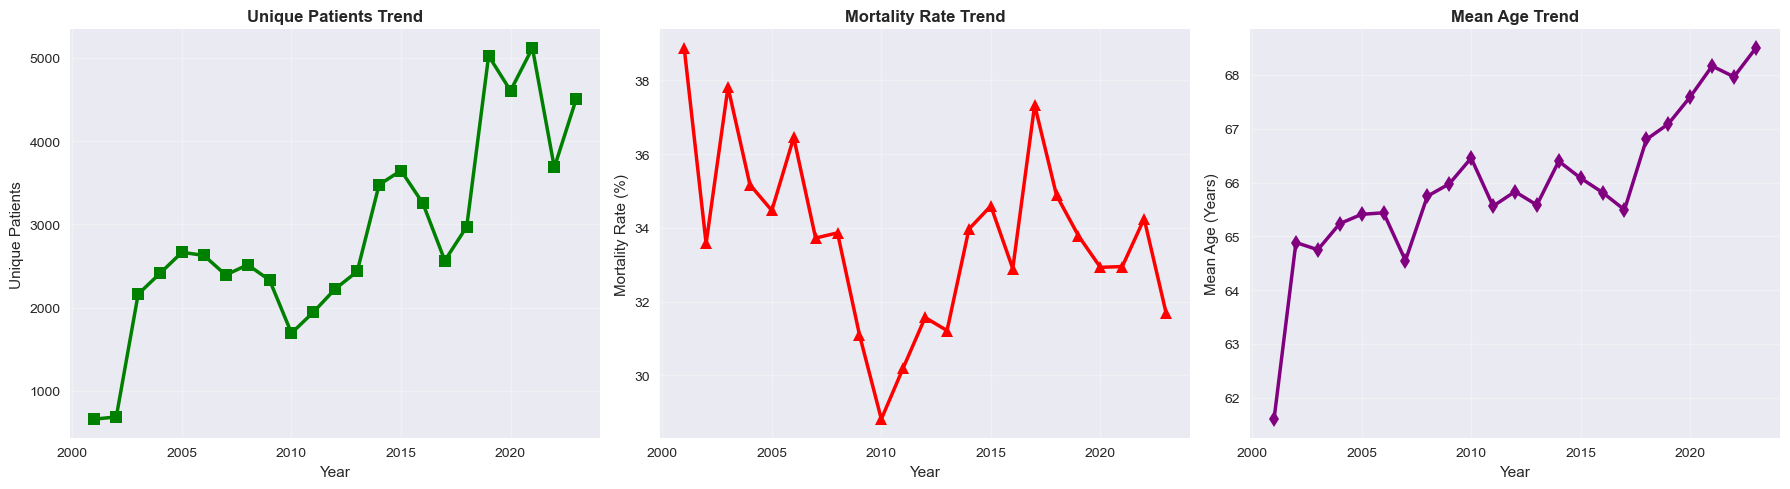

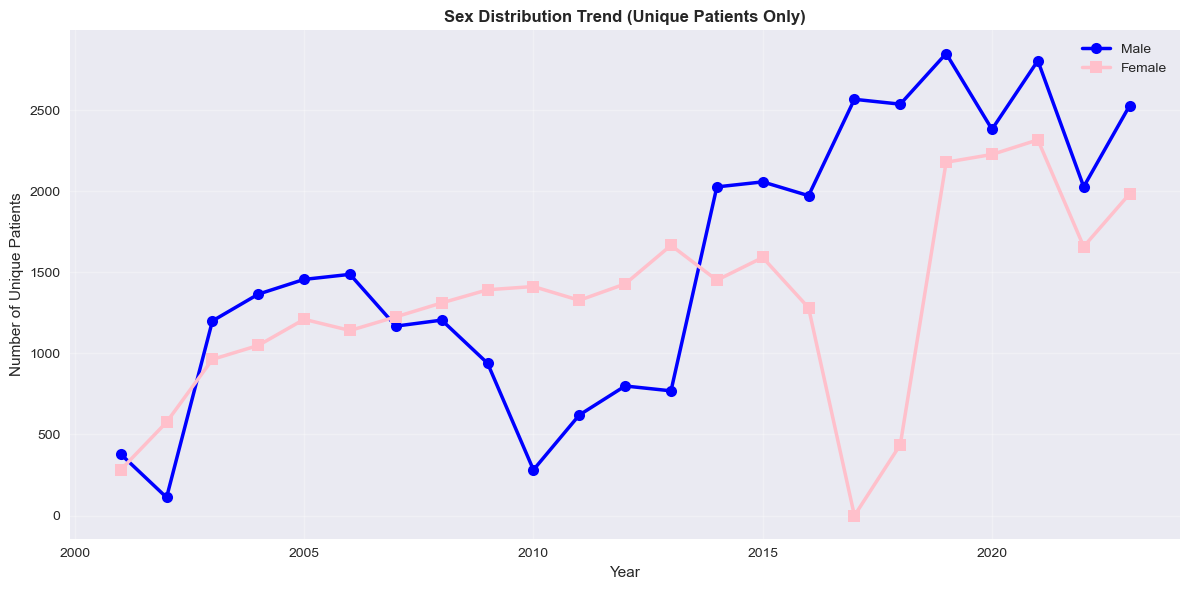

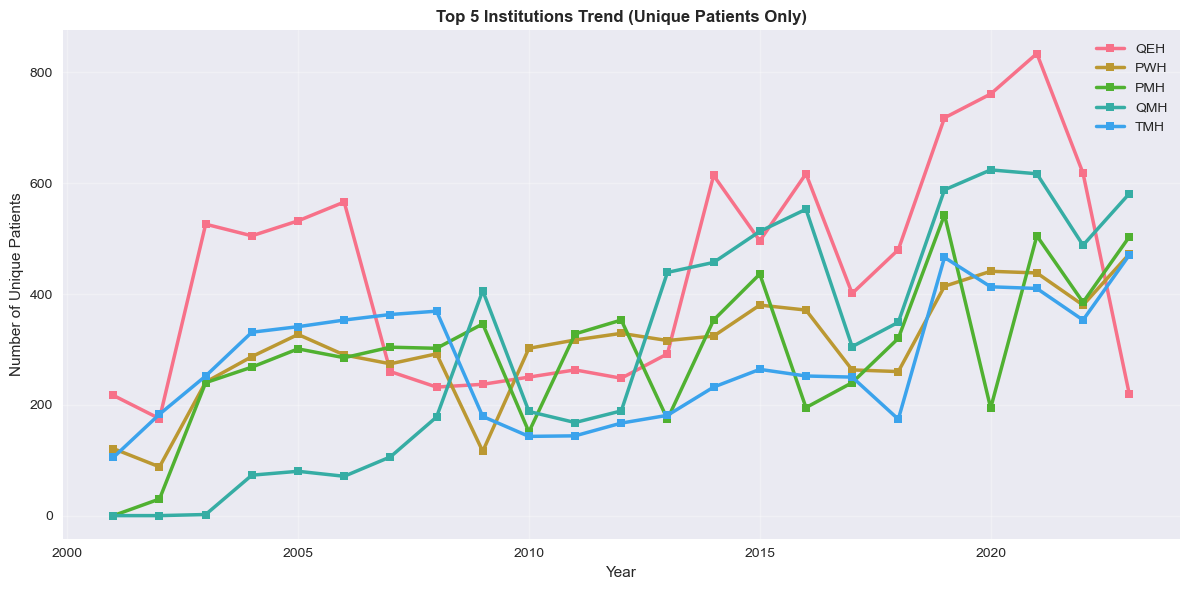

C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\1285142487.py:257: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\1285142487.py:257: UserWarning: Glyph 22283 (\N{CJK UNIFIED IDEOGRAPH-570B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\1285142487.py:257: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\1285142487.py:257: UserWarning: Glyph 38520 (\N{CJK UNIFIED IDEOGRAPH-9678}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\1285142487.py:257: UserWarning: Glyph 33778 (\N{CJK UNIFIED IDEOGRAPH-83F2}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Vincent Yeung\AppData\Local\Temp\ipykernel_48264\1285142487.py:257: Use

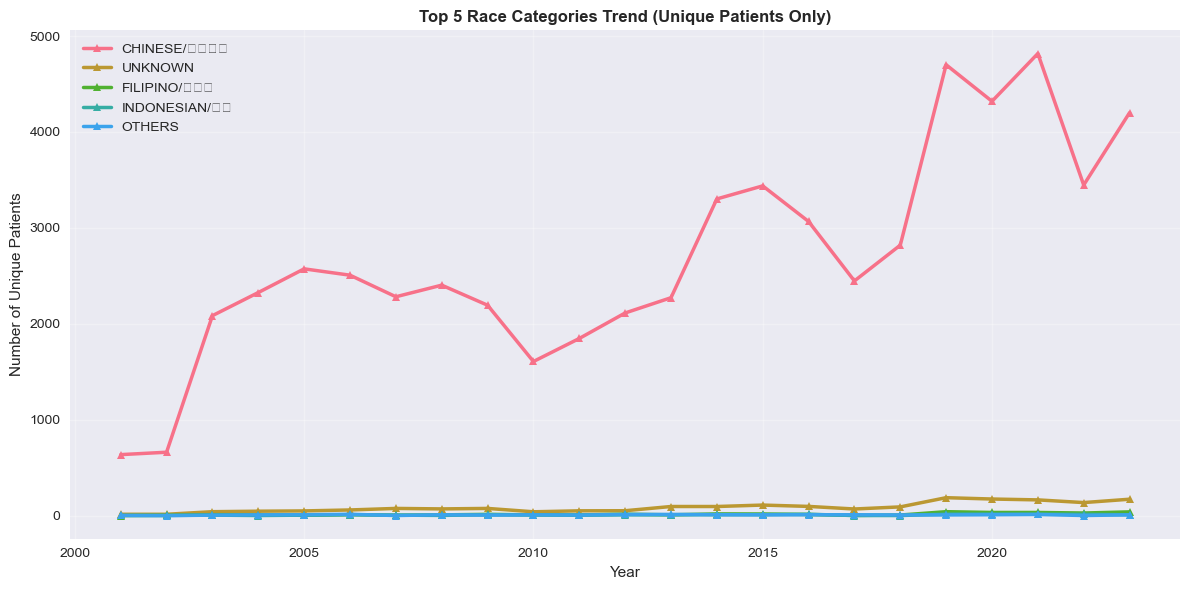

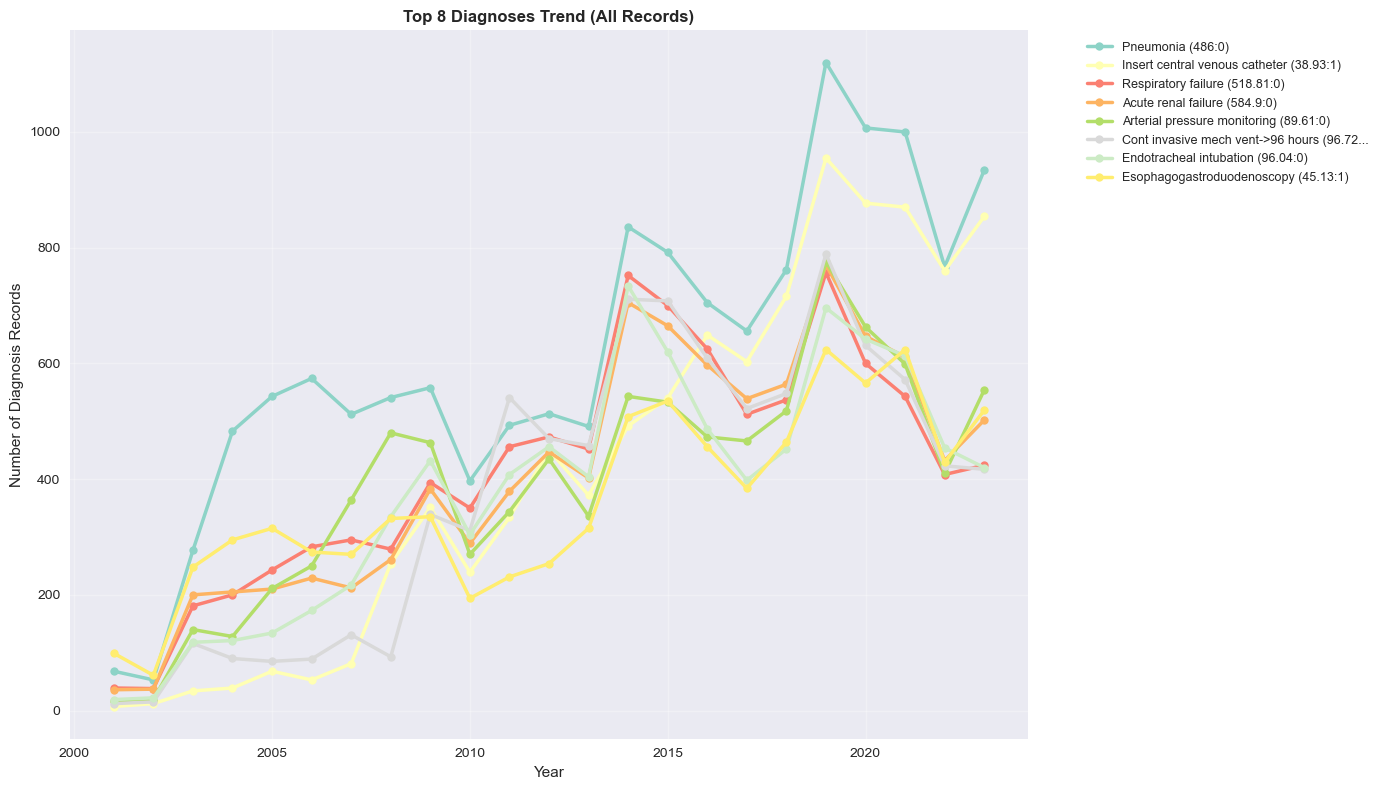


✅ Trend analysis complete! All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/trend_analysis/


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from collections import Counter

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_demographic_data():
    """Load the filtered demographic data"""
    input_file = "./Sepsis_plt/demographic/filtered_approved_hn/demographic_ALL_YEARS_filtered.csv"
    
    if not os.path.exists(input_file):
        print(f"Error: Filtered demographic file not found at {input_file}")
        return None
    
    print("Loading demographic data...")
    try:
        df = pd.read_csv(input_file)
        print(f"✓ Loaded {len(df):,} rows from demographic data")
        return df
    except Exception as e:
        print(f"✗ Error loading demographic data: {e}")
        return None

def analyze_trends_over_years(df):
    """Analyze trends across all years - counting unique patients only"""
    if 'Year' not in df.columns or 'Reference Key' not in df.columns:
        print("✗ Required columns not found for trend analysis")
        return
    
    print("\n" + "="*60)
    print("TREND ANALYSIS OVER YEARS (UNIQUE PATIENTS ONLY)")
    print("="*60)
    
    years = sorted(df['Year'].unique())
    print(f"Years available: {years}")
    
    # Create output folder for trend analysis
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/trend_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    # Initialize trend data
    trend_data = []
    
    for year in years:
        year_data = df[df['Year'] == year]
        
        # Get unique patients for this year (remove duplicates by Reference Key)
        unique_patients = year_data.drop_duplicates(subset=['Reference Key'])
        year_stats = {'Year': year, 'Unique_Patients': len(unique_patients)}
        
        print(f"Year {year}: {len(unique_patients):,} unique patients")
        
        # Sex distribution - using unique patients only
        if 'Sex' in df.columns:
            # Convert to string and strip whitespace for consistent counting
            sex_data = unique_patients['Sex'].astype(str).str.strip().str.upper()
            
            # Count using string comparison
            male_count = len(sex_data[sex_data.isin(['M', 'MALE', '1'])])
            female_count = len(sex_data[sex_data.isin(['F', 'FEMALE', '2'])])
            
            print(f"  Male: {male_count}, Female: {female_count}")
            
            year_stats['Sex_M'] = male_count
            year_stats['Sex_F'] = female_count
            year_stats['Sex_M_Pct'] = male_count / len(unique_patients) * 100 if len(unique_patients) > 0 else 0
            year_stats['Sex_F_Pct'] = female_count / len(unique_patients) * 100 if len(unique_patients) > 0 else 0
        
        # Age statistics - using unique patients only
        if 'Admission Age (Year) (episode based)' in df.columns:
            age_data = unique_patients['Admission Age (Year) (episode based)'].dropna()
            if len(age_data) > 0:
                year_stats['Mean_Age'] = age_data.mean()
                year_stats['Median_Age'] = age_data.median()
        
        # Mortality - using unique patients only
        if 'Episode Death (Y/N)' in df.columns:
            death_data = unique_patients['Episode Death (Y/N)'].value_counts()
            if 'Y' in death_data:
                year_stats['Death_Count'] = death_data['Y']
                year_stats['Mortality_Rate'] = death_data['Y'] / len(unique_patients) * 100
        
        # Institution - using unique patients only
        if 'Institution (IPAS)' in df.columns:
            institution_counts = unique_patients['Institution (IPAS)'].value_counts()
            year_stats['Top_Institution'] = institution_counts.index[0] if len(institution_counts) > 0 else 'Unknown'
            year_stats['Top_Institution_Count'] = institution_counts.iloc[0] if len(institution_counts) > 0 else 0
        
        # Race - using unique patients only
        if 'Race Description' in df.columns:
            race_counts = unique_patients['Race Description'].value_counts()
            year_stats['Top_Race'] = race_counts.index[0] if len(race_counts) > 0 else 'Unknown'
            year_stats['Top_Race_Count'] = race_counts.iloc[0] if len(race_counts) > 0 else 0
        
        trend_data.append(year_stats)
    
    # Convert to DataFrame
    trends_df = pd.DataFrame(trend_data)
    
    # Save trend data
    trends_file = os.path.join(output_folder, "yearly_trends_unique_patients.csv")
    trends_df.to_csv(trends_file, index=False)
    print(f"✓ Yearly trends (unique patients) saved to: {trends_file}")
    
    return trends_df

def create_trend_plots(df, trends_df):
    """Create trend visualization plots for unique patients only"""
    output_folder = "./Sepsis_plt/demographic/filtered_approved_hn/trend_analysis/"
    os.makedirs(output_folder, exist_ok=True)
    
    years = trends_df['Year']
    
    # Plot 1: Key metrics trends
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Unique patients trend
    if 'Unique_Patients' in trends_df.columns:
        ax1.plot(years, trends_df['Unique_Patients'], marker='s', linewidth=2.5, markersize=8, color='green')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Unique Patients')
        ax1.set_title('Unique Patients Trend', fontweight='bold')
        ax1.grid(True, alpha=0.3)
    
    # Mortality rate trend
    if 'Mortality_Rate' in trends_df.columns:
        ax2.plot(years, trends_df['Mortality_Rate'], marker='^', linewidth=2.5, markersize=8, color='red')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Mortality Rate (%)')
        ax2.set_title('Mortality Rate Trend', fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    # Mean age trend
    if 'Mean_Age' in trends_df.columns:
        ax3.plot(years, trends_df['Mean_Age'], marker='d', linewidth=2.5, markersize=8, color='purple')
        ax3.set_xlabel('Year')
        ax3.set_ylabel('Mean Age (Years)')
        ax3.set_title('Mean Age Trend', fontweight='bold')
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'key_metrics_trends_unique_patients.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Sex distribution trends (unique patients only)
    if 'Sex_M' in trends_df.columns and 'Sex_F' in trends_df.columns:
        plt.figure(figsize=(12, 6))
        
        male_counts = trends_df['Sex_M'].fillna(0).astype(int)
        female_counts = trends_df['Sex_F'].fillna(0).astype(int)
        
        plt.plot(years, male_counts, marker='o', linewidth=2.5, label='Male', color='blue', markersize=8)
        plt.plot(years, female_counts, marker='s', linewidth=2.5, label='Female', color='pink', markersize=8)
        
        plt.xlabel('Year')
        plt.ylabel('Number of Unique Patients')
        plt.title('Sex Distribution Trend (Unique Patients Only)', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, 'sex_distribution_trend_unique.png'), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Additional analyses
    analyze_institution_trends_unique(df, output_folder)
    analyze_race_trends_unique(df, output_folder)
    
    # Diagnosis trends (still using all records since diagnoses can be multiple per patient)
    analyze_diagnosis_trends(df, output_folder)

def analyze_institution_trends_unique(df, output_folder):
    """Analyze institution trends for unique patients only"""
    if 'Institution (IPAS)' not in df.columns or 'Reference Key' not in df.columns:
        return
    
    years = sorted(df['Year'].unique())
    
    # Get top 5 institutions across all years (using unique patients)
    unique_patients_all = df.drop_duplicates(subset=['Reference Key'])
    top_5_all = unique_patients_all['Institution (IPAS)'].value_counts().head(5)
    top_institutions = [inst for inst, count in top_5_all.items()]
    
    # Create trend data for top institutions
    institution_trends = []
    for institution in top_institutions:
        trend = {'Institution': institution}
        for year in years:
            year_data = df[df['Year'] == year]
            unique_patients_year = year_data.drop_duplicates(subset=['Reference Key'])
            institution_count = len(unique_patients_year[unique_patients_year['Institution (IPAS)'] == institution])
            trend[year] = institution_count
        institution_trends.append(trend)
    
    institution_trends_df = pd.DataFrame(institution_trends)
    institution_trends_df.to_csv(os.path.join(output_folder, "institution_trends_unique.csv"), index=False)
    
    # Plot institution trends
    plt.figure(figsize=(12, 6))
    for institution in top_institutions:
        trend_data = institution_trends_df[institution_trends_df['Institution'] == institution].iloc[0]
        counts = [trend_data[year] for year in years]
        plt.plot(years, counts, marker='s', linewidth=2.5, label=institution, markersize=6)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Unique Patients')
    plt.title('Top 5 Institutions Trend (Unique Patients Only)', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'institution_trends_unique.png'), dpi=150, bbox_inches='tight')
    plt.show()

def analyze_race_trends_unique(df, output_folder):
    """Analyze race trends for unique patients only"""
    if 'Race Description' not in df.columns or 'Reference Key' not in df.columns:
        return
    
    years = sorted(df['Year'].unique())
    
    # Get top 5 races across all years (using unique patients)
    unique_patients_all = df.drop_duplicates(subset=['Reference Key'])
    top_5_all = unique_patients_all['Race Description'].value_counts().head(5)
    top_races = [race for race, count in top_5_all.items()]
    
    # Create trend data for top races
    race_trends = []
    for race in top_races:
        trend = {'Race': race}
        for year in years:
            year_data = df[df['Year'] == year]
            unique_patients_year = year_data.drop_duplicates(subset=['Reference Key'])
            race_count = len(unique_patients_year[unique_patients_year['Race Description'] == race])
            trend[year] = race_count
        race_trends.append(trend)
    
    race_trends_df = pd.DataFrame(race_trends)
    race_trends_df.to_csv(os.path.join(output_folder, "race_trends_unique.csv"), index=False)
    
    # Plot race trends
    plt.figure(figsize=(12, 6))
    for race in top_races:
        trend_data = race_trends_df[race_trends_df['Race'] == race].iloc[0]
        counts = [trend_data[year] for year in years]
        plt.plot(years, counts, marker='^', linewidth=2.5, label=race, markersize=6)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Unique Patients')
    plt.title('Top 5 Race Categories Trend (Unique Patients Only)', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'race_trends_unique.png'), dpi=150, bbox_inches='tight')
    plt.show()

def analyze_diagnosis_trends(df, output_folder):
    """Analyze diagnosis trends (using all records since patients can have multiple diagnoses)"""
    if 'Dx/Px Description (HAMDCT)' not in df.columns or 'Year' not in df.columns:
        return
    
    years = sorted(df['Year'].unique())
    
    # Get top 8 diagnoses across all years (using all records)
    all_diagnoses = df['Dx/Px Description (HAMDCT)'].dropna()
    top_8_all = Counter(all_diagnoses).most_common(8)
    top_diagnoses = [diag for diag, count in top_8_all]
    
    # Create trend data for top diagnoses
    diagnosis_trends = []
    for diagnosis in top_diagnoses:
        trend = {'Diagnosis': diagnosis}
        for year in years:
            year_data = df[df['Year'] == year]
            diagnosis_count = len(year_data[year_data['Dx/Px Description (HAMDCT)'] == diagnosis])
            trend[year] = diagnosis_count
        diagnosis_trends.append(trend)
    
    diagnosis_trends_df = pd.DataFrame(diagnosis_trends)
    diagnosis_trends_df.to_csv(os.path.join(output_folder, "diagnosis_trends_all_records.csv"), index=False)
    
    # Plot diagnosis trends
    plt.figure(figsize=(14, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_diagnoses)))
    
    for i, (diagnosis, color) in enumerate(zip(top_diagnoses, colors)):
        trend_data = diagnosis_trends_df[diagnosis_trends_df['Diagnosis'] == diagnosis].iloc[0]
        counts = [trend_data[year] for year in years]
        plt.plot(years, counts, marker='o', linewidth=2.5, label=diagnosis[:40] + '...' if len(diagnosis) > 40 else diagnosis, color=color, markersize=6)
    
    plt.xlabel('Year')
    plt.ylabel('Number of Diagnosis Records')
    plt.title('Top 8 Diagnoses Trend (All Records)', fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'diagnosis_trends_all_records.png'), dpi=150, bbox_inches='tight')
    plt.show()

def main():
    """Main function for trend analysis"""
    print("Analyzing trends over years (unique patients only)...")
    
    # Load data
    df = load_demographic_data()
    if df is None:
        return
    
    # Analyze trends
    trends_df = analyze_trends_over_years(df)
    
    if trends_df is not None:
        # Create trend plots
        create_trend_plots(df, trends_df)
        
        print(f"\n✅ Trend analysis complete! All outputs saved to: ./Sepsis_plt/demographic/filtered_approved_hn/trend_analysis/")
    else:
        print("✗ No trend data could be analyzed")

if __name__ == "__main__":
    main()